
<div style="background-color:#CCCCCC; padding:12px; border-radius:8px;">
<h1 style="color:#003366; text-align:center; margin:8px 0;">Revisión y limpieza de 3 DataFrames (TPI - Data Analytics)</h1>
<p style="text-align:center; color:#003366; margin:0;"><em>Notebook docente en castellano — nombres descriptivos en snake_case — código y documentación</em></p>
</div>



<div style="background-color:#CCCCCC; padding:10px; border-radius:6px;">
<h2 style="color:black; text-align:center; margin-top:6px;">Resumen</h2>
<p style="color:black;">
Este notebook está diseñado con finalidades pedagógicas. Revisa, normaliza y valida tres datasets contenidos en CSV:
</p></div>
<div style="background-color:#CCCCCC; padding:10px; border-radius:6px;">    
<ul style="color:black;">
<li><code>marketing.csv</code> → variable: <code>df_marketing</code></li>
<li><code>ventas.csv</code>    → variable: <code>df_ventas</code></li>
<li><code>clientes.csv</code>  → variable: <code>df_clientes</code></li>
</ul>
<p style="color:black;">
Coloca los CSV en <code>/content/drive/MyDrive/CABA/Garcia Traba Ariel H - Comisión 25262 - TPI Data Analytics/</code> 
    en <code>/datasets_entrada/</code>. El notebook busca primero en google drive y si no encuentra, usa <code>localhost (127.0.0.1)</code> (útil para entornos donde los archivos están pre-subidos).
</p>
</div>


## 1- Crear un documento en Google Colaboratory y cargar los sets de datos como DataFrames.

si se usa en disco local comentarla celda de debajo (JuPyteR , VSC, ATOM, Spider, Geany, etc)

# 1ra parte Definición de ETL
ETL es un conjunto de procedimientos que permiten mover datos desde sistemas de origen, que pueden ser bases de datos, archivos o fuentes en la nube, hasta un sistema de destino como un data warehouse o data lake, realizando previamente procesos de limpieza, estructuración y organización de los datos para hacerlos aptos para análisis.​

## Fases del proceso ETL
Extracción: Consiste en recopilar datos relevantes de diferentes fuentes, asegurando que el impacto en los sistemas origen sea mínimo. Los datos pueden extraerse mediante diversos métodos como consultas SQL o servicios web.​

Transformación: En esta etapa, los datos se limpian y se ajustan para garantizar coherencia y calidad, incluyendo la eliminación de valores nulos, normalización y conversión a formatos consistentes, además de aplicar reglas específicas de negocio.

Carga: Finalmente, los datos transformados se cargan en el sistema de destino, donde estarán disponibles para análisis, informes o modelado de datos.

## Importancia del ETL
Es crucial en la minería de datos porque preparar los datos brutos para que puedan ser utilizados en análisis estadísticos, modelados predictivos o técnicas de aprendizaje automático, asegurando la calidad, coherencia y accesibilidad de la información.

In [1]:
import os
import re
import json
import unicodedata
import csv
import sys
from pathlib import Path
from datetime import datetime
from math import isnan
import zipfile
from collections import defaultdict
import argparse
from typing import Dict, Any, Optional

In [2]:
import importlib
import subprocess
import sys
paquetes = ["colorama", "pandas", "numpy", "matplotlib", "seaborn"]
for pkg in paquetes:
    try:
        importlib.import_module(pkg)
    except ImportError:
        print(f"Instalando {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

In [3]:
try:
    from colorama import Fore, Style, Back
except Exception:
    class _Dummy:
        RED = GREEN = CYAN = WHITE = RESET = ""
    Fore = _Dummy()
    Style = _Dummy()
    Back = _Dummy()
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1.1 - Crear estructura de directorios segun modelo

## 1.2 -Carga de fuente de datos

<div style="background-color:#CCCCCC; padding:10px; border-radius:6px;">
<h1 style="color:green; text-align:center; margin-top:6px;">SIN PANDAS</h1>
</div>
<div style="background-color:#CCCCCC; padding:10px; border-radius:6px;">
<h2 style="color:black; text-align:center; margin-top:6px;">Resumen</h2>
<p style="color:black;">Lectura de csv a estructuras de <span style="color:blue;">diccionarios</span> <span style="color:black;">y</span> <span style="color:blue;">listas anidados</span></p>



<ul style="color:black;">
<li><code>marketing.csv</code> → variable: <code>df_marketing</code></li>
<li><code>ventas.csv</code>    → variable: <code>df_ventas</code></li>
<li><code>clientes.csv</code>  → variable: <code>df_clientes</code></li>
</ul>

<p style="color:black;">
Coloca los CSV en <code>/content/drive/MyDrive/CABA/Garcia Traba Ariel H - Comisión 25262 - TPI Data Analytics/</code> 
    en <code>/datasets_entrada/</code>. El notebook busca primero en google drive y si no encuentra, usa <code>localhost (127.0.0.1)</code> (útil para entornos donde los archivos están pre-subidos).
</p>
</div>

# 2- Realizar un script básico que calcule las ventas mensuales utilizando variables y operadores.

### RUTAS Y CARGA DE ARCHIVOS

In [4]:
def carga_rutas():
    """
    Construye las rutas de trabajo a partir de `ruta_base`.
    Crea carpetas de salida si no existen y define globals:
      carpeta_entrada, carpeta_datasets_entrada, carpeta_datasets_salida,
      carpeta_reportes, carpeta_limpios
    """
    global carpeta_entrada, carpeta_datasets_entrada, carpeta_datasets_salida
    global carpeta_reportes, carpeta_limpios

    if 'ruta_base' not in globals():
        raise RuntimeError("Definí la variable global `ruta_base` antes de llamar a carga_rutas()")

    try:
        carpeta_entrada = Path(ruta_base).expanduser().resolve()
        carpeta_datasets_entrada = carpeta_entrada / 'datasets_entrada'

        carpeta_datasets_salida = carpeta_entrada / 'datasets_salida'
        carpeta_datasets_salida.mkdir(parents=True, exist_ok=True)

        carpeta_reportes = carpeta_datasets_salida / 'reportes'
        carpeta_reportes.mkdir(parents=True, exist_ok=True)

        carpeta_limpios = carpeta_datasets_salida / 'limpios'
        carpeta_limpios.mkdir(parents=True, exist_ok=True)

        print(f"{Fore.GREEN}Rutas configuradas correctamente:{Style.RESET_ALL}")
        print(f"  carpeta_entrada:          {carpeta_entrada}")
        print(f"  carpeta_datasets_entrada: {carpeta_datasets_entrada}")
        print(f"  carpeta_datasets_salida:  {carpeta_datasets_salida}")
        print(f"  carpeta_reportes:         {carpeta_reportes}")
        print(f"  carpeta_limpios:          {carpeta_limpios}")

    except Exception as e:
        print(f"{Fore.WHITE+Back.RED}Error creando rutas: {e}{Style.RESET_ALL}")
        raise

### 2.1 leer csvs

In [5]:
def read_csv_to_table(ruta, encoding='utf-8', delimiter=','):
    """
    Helper que lee un CSV y devuelve una 'tabla' sin pandas:
    { 'rows': [dict,...], 'cols': {col: [vals...]}, 'nrows': int, 'ncols': int, 'columns': [...] }
    """
    ruta = Path(ruta)
    if not ruta.exists():
        raise FileNotFoundError(f"Archivo no encontrado: {ruta}")

    with ruta.open(newline='', encoding=encoding) as f:
        reader = csv.DictReader(f, delimiter=delimiter)
        columns = reader.fieldnames or []
        rows = [row for row in reader]

    cols = defaultdict(list)
    for row in rows:
        for col in columns:
            cols[col].append(row.get(col, ''))

    if not rows and columns:
        for col in columns:
            cols[col] = []

    return {
        'rows': rows,
        'cols': dict(cols),
        'nrows': len(rows),
        'ncols': len(columns),
        'columns': columns
    }

In [6]:
def carga_de_datos_sin_pandas():
    """
    Carga 3 CSV (ventas, clientes, marketing) SIN usar pandas/numpy.
    Usa las globals: carpeta_datasets_entrada, archivo_ventas, archivo_clientes, archivo_marketing
    PISA la global dic_dfs con las claves: 'df_ventas', 'df_clientes', 'df_marketing'
    """
    global dic_dfs
    dic_dfs = {}

    required = ['carpeta_datasets_entrada', 'archivo_ventas', 'archivo_clientes', 'archivo_marketing']
    miss = [v for v in required if v not in globals()]
    if miss:
        raise RuntimeError(f"Faltan variables globales: {miss}. Definilas antes de llamar a esta función.")

    carpeta = Path(globals()['carpeta_datasets_entrada'])
    archivos = {
        'df_ventas': globals()['archivo_ventas'],
        'df_clientes': globals()['archivo_clientes'],
        'df_marketing': globals()['archivo_marketing']
    }

    encoding = 'utf-8'
    delimiter = ','

    print(f"{Fore.WHITE+Back.BLUE}\n╔════════════════════════════════════════════════════╗")
    print("║            CARGA DE DATOS (SIN PANDAS)             ║")
    print("╚════════════════════════════════════════════════════╝" + Style.RESET_ALL)

    for nombre_key, archivo in archivos.items():
        ruta = carpeta / archivo
        print(f"\nLeyendo -> {nombre_key}  |  Archivo: {ruta}")

        if not ruta.exists():
            print(f"{Fore.RED}✖ Archivo no encontrado: {ruta}  -> se crea entrada vacía{Style.RESET_ALL}")
            dic_dfs[nombre_key] = {
                'rows': [],
                'cols': {},
                'nrows': 0,
                'ncols': 0,
                'columns': []
            }
            continue

        try:
            tabla = read_csv_to_table(ruta, encoding=encoding, delimiter=delimiter)
            dic_dfs[nombre_key] = tabla
            print(f"{Fore.GREEN}✔ {nombre_key}: {tabla['nrows']} filas, {tabla['ncols']} columnas{Style.RESET_ALL}")
        except Exception as e:
            print(f"{Fore.RED}✖ Error leyendo {ruta}: {e}{Style.RESET_ALL}")
            dic_dfs[nombre_key] = {
                'rows': [],
                'cols': {},
                'nrows': 0,
                'ncols': 0,
                'columns': []
            }

    # Validación rápida de columnas
    print("\nValidación rápida de columnas entre datasets:")
    pairs = [('df_ventas','df_marketing'), ('df_ventas','df_clientes'), ('df_clientes','df_marketing')]
    for a,b in pairs:
        cols_a = set(dic_dfs.get(a, {}).get('columns', []))
        cols_b = set(dic_dfs.get(b, {}).get('columns', []))
        inter = cols_a.intersection(cols_b)
        if inter:
            muestra = sorted(list(inter))[:10]
            print(f" → {a} ∩ {b} : {len(inter)} columnas en común -> {muestra}{'...' if len(inter)>10 else ''}")
        else:
            print(f" → {a} ∩ {b} : 0 columnas en común")

    print(f"\n{Fore.WHITE+Back.BLUE}<════════════════════════════════════════════════════>{Style.RESET_ALL}")
    print("Carga finalizada. `dic_dfs` ha sido pisado con estructuras tipo tabla (sin pandas).")
    return None

### 2.2 PARSERS Y CÁLCULO

In [7]:
def parse_price(s):
    """
    Normaliza y parsea precios. Maneja formatos como:
      $1,234.56  o  1.234,56  o  1234.56  o  1234
    Retorna float (0.0 si no puede)
    """
    s = (s or "").strip()
    if s == "":
        return 0.0
    # eliminar símbolo de moneda y espacios
    s = s.replace('$','').replace(' ','')
    # caso común: separador de miles con coma -> '1,234' pero a veces el csv trae '1,234.56'
    # Intento dos estrategias:
    try:
        # método simple: quitar comas (si son miles) y convertir
        return float(s.replace(',',''))
    except:
        # alternativa: si usan '.' como miles y ',' como decimal -> convertir a notación punto
        s2 = s.replace('.','').replace(',','.')
        try:
            return float(s2)
        except:
            return 0.0

In [8]:
def calcular_ventas_desde_rows(rows):
    """
    Calcula ventas mensuales a partir de rows = dic_dfs['df_ventas']['rows']
    Devuelve (ordered_monthly_dict, total, filas_leidas)
    """
    monthly = defaultdict(float)
    total = 0.0
    n_rows = 0

    for row in rows:
        n_rows += 1
        precio = parse_price(row.get('precio','0'))
        cantidad_raw = row.get('cantidad','1')
        try:
            cantidad = int(float(cantidad_raw))
        except:
            cantidad = 1
        importe = precio * cantidad

        fecha_str = (row.get('fecha_venta') or '').strip()
        fecha = None
        for fmt in ("%d/%m/%Y","%Y-%m-%d","%d-%m-%Y","%m/%d/%Y"):
            try:
                fecha = datetime.strptime(fecha_str, fmt)
                break
            except:
                continue
        if fecha is None:
            key = 'unknown'
        else:
            key = f"{fecha.year}-{fecha.month:02d}"

        monthly[key] += importe
        total += importe

    # ordenar cronológicamente y colocar 'unknown' al final si existe
    ordered = {k: monthly[k] for k in sorted([k for k in monthly if k!='unknown'])}
    if 'unknown' in monthly:
        ordered['unknown'] = monthly['unknown']
    return ordered, total, n_rows

### 2.3 REPORTES (CSV + PNG)

In [9]:
def guardar_reporte_mensual_csv(monthly_dict, total, ruta_salida):
    """
    Guarda un CSV con columnas: mes, ventas
    monthly_dict: dict ordenado {'YYYY-MM': importe, ...}
    ruta_salida: Path o str al archivo .csv de salida
    """
    try:
        ruta = Path(ruta_salida)
        ruta.parent.mkdir(parents=True, exist_ok=True)
        with ruta.open('w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['mes','ventas'])
            for k,v in monthly_dict.items():
                writer.writerow([k, f"{v:.2f}"])
            writer.writerow(['TOTAL', f"{total:.2f}"])
        print(f"{Fore.GREEN}✔ Reporte guardado en: {ruta}{Style.RESET_ALL}")
    except Exception as e:
        print (f"Error {e}")
    ruta = Path(ruta_salida)
    ruta.parent.mkdir(parents=True, exist_ok=True)
    with ruta.open('w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['mes','ventas'])
        for k,v in monthly_dict.items():
            writer.writerow([k, f"{v:.2f}"])
        writer.writerow(['TOTAL', f"{total:.2f}"])
    print(f"{Fore.GREEN}✔ Reporte guardado en: {ruta}{Style.RESET_ALL}")
    

In [10]:
def graficar_ventas_mensuales(monthly_dict, ruta_png):
    """
    Genera y guarda una gráfica PNG simple de ventas mensuales.
    """
    ruta = Path(ruta_png)
    ruta.parent.mkdir(parents=True, exist_ok=True)

    meses = list(monthly_dict.keys())
    valores = [monthly_dict[m] for m in meses]

    plt.figure(figsize=(10,5))
    plt.plot(meses, valores, marker='o')
    plt.title('Ventas mensuales')
    plt.xlabel('Mes')
    plt.ylabel('Ventas (importe)')
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(ruta, dpi=150)
    plt.show()
    plt.close()
    print(f"{Fore.GREEN}✔ Gráfica guardada en: {ruta}{Style.RESET_ALL}")


### 2.4 MAIN (flujo)

In [11]:
def main(args):
    """
    Flujo principal:
      - configurar rutas (ruta_base debe estar definida o usarse --ruta)
      - cargar datos (sin pandas)
      - calcular ventas mensuales desde dic_dfs
      - guardar reporte y gráfica si se solicita
    """
    # Si se pasó ruta por argumento, sobrescribo ruta_base global
    global ruta_base, archivo_ventas, archivo_clientes, archivo_marketing

    if args.ruta_base:
        ruta_base = args.ruta_base

    # nombres de archivos (pueden pasar por args)
    archivo_ventas = args.ventas or globals().get('archivo_ventas', 'ventas.csv')
    archivo_clientes = args.clientes or globals().get('archivo_clientes', 'clientes.csv')
    archivo_marketing = args.marketing or globals().get('archivo_marketing', 'marketing.csv')

    # configurar rutas y cargar
    carga_rutas()
    carga_de_datos_sin_pandas()

    # calcular ventas desde dic_dfs
    rows_ventas = dic_dfs.get('df_ventas', {}).get('rows', [])
    if not rows_ventas:
        print(f"{Fore.RED}No se encontraron filas en df_ventas. Abortando cálculo.{Style.RESET_ALL}")
        return

    monthly, total, filas = calcular_ventas_desde_rows(rows_ventas)

    # imprimir resultado en consola
    print("\nVentas mensuales (importe):\n")
    print(f"{'Mes':<10} | {'Ventas':>15}")
    print("-"*28)
    for k,v in monthly.items():
        print(f"{k:<10} | {v:15.2f}")
    print("-"*28)
    print(f"{'TOTAL':<10} | {total:15.2f}")
    print(f"\nFilas procesadas: {filas}")

    if args.guardar_reporte:
        ruta_csv = Path(carpeta_reportes) / f"ventas_mensuales_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        guardar_reporte_mensual_csv(monthly, total, ruta_csv)

    if args.guardar_grafica:
        ruta_png = Path(carpeta_reportes) / f"ventas_mensuales_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        graficar_ventas_mensuales(monthly, ruta_png)

    print(f"\n{Fore.CYAN}Operación completada. Puedes revisar los archivos en: {carpeta_reportes}{Style.RESET_ALL}")

### 2.5 PARSEO DE ARGUMENTOS

In [12]:
def menu_sin_pandas():
    import sys
    # Ignorar argumentos que Jupyter pasa automáticamente
    sys.argv = sys.argv[:1]

    parser = argparse.ArgumentParser(description="Calcular ventas mensuales SIN pandas")
    parser.add_argument('--ruta-base', dest='ruta_base', help='Ruta base del proyecto')
    parser.add_argument('--ventas', help='Archivo ventas.csv')
    parser.add_argument('--clientes', help='Archivo clientes.csv')
    parser.add_argument('--marketing', help='Archivo marketing.csv')
    parser.add_argument('--guardar-reporte', dest='guardar_reporte', action='store_true')
    parser.add_argument('--guardar-grafica', dest='guardar_grafica', action='store_true')
    parsed = parser.parse_args([])  # <-- vacío, no toma nada de Jupyter

    # definir por defecto tus rutas
    ruta_base = "./"
    archivo_ventas = "ventas.csv"
    archivo_clientes = "clientes.csv"
    archivo_marketing = "marketing.csv"

    parsed.ruta_base = ruta_base
    parsed.guardar_reporte = True
    parsed.guardar_grafica = False

    main(parsed)
menu_sin_pandas()

Rutas configuradas correctamente:
  carpeta_entrada:          D:\Desktop\Domingo\df_caba_y_jupyter
  carpeta_datasets_entrada: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_entrada
  carpeta_datasets_salida:  D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida
  carpeta_reportes:         D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida\reportes
  carpeta_limpios:          D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida\limpios

╔════════════════════════════════════════════════════╗
║            CARGA DE DATOS (SIN PANDAS)             ║
╚════════════════════════════════════════════════════╝

Leyendo -> df_ventas  |  Archivo: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_entrada\ventas.csv
✔ df_ventas: 3035 filas, 6 columnas

Leyendo -> df_clientes  |  Archivo: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_entrada\clientes.csv
✔ df_clientes: 578 filas, 5 columnas

Leyendo -> df_marketing  |  Archivo: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_entrada\marketing.csv
✔ df_marke

### 2.6 Helpers (parsing / util)

In [13]:
def parse_price(s):
    """Convierte cadenas de precio a float manejando $, comas y puntos."""
    s = (s or "").strip()
    if s == "":
        return 0.0
    s = s.replace('$','').replace(' ','')
    try:
        # intento simple: quitar comas (miles) y parsear
        return float(s.replace(',',''))
    except:
        s2 = s.replace('.','').replace(',','.')
        try:
            return float(s2)
        except:
            return 0.0

In [14]:
def parse_int(s):
    """Convierte a int de forma segura, devolviendo 0 si falla."""
    try:
        return int(float((s or "").strip()))
    except:
        return 0

In [15]:
def is_missing_value(val):
    """Detecta valores vacíos o marcadores tipo 'nono','nan','none' (case-insensitive)."""
    if val is None:
        return True
    v = str(val).strip()
    if v == "":
        return True
    if v.lower() in {"nono","nan","none","na","n/a","null"}:
        return True
    return False


In [16]:
def safe_get(row, key):
    """Obtiene valor de diccionario row de forma segura (devuelve '' si no existe)."""
    return row.get(key, '') if isinstance(row, dict) else ''

### 2.7 Operaciones principales

In [17]:
def generar_precio_total(dic_dfs, carpeta_limpios):
    """
    Calcula precio_total por fila en ventas y guarda CSV ventas_precio_total.csv.
    Devuelve rows_ventas_actualizado (lista de dicts con nueva clave 'precio_total').
    """
    ventas = dic_dfs.get('df_ventas', {}).get('rows', [])
    if ventas is None:
        ventas = []
    out_rows = []
    missing_rows = []
    for row in ventas:
        precio_raw = safe_get(row, 'precio')
        cantidad_raw = safe_get(row, 'cantidad')
        precio = parse_price(precio_raw)
        cantidad = parse_int(cantidad_raw) or 0
        precio_total = precio * cantidad
        # agregar campo (como string con 2 decimales para CSV)
        new_row = dict(row)  # copia superficial
        new_row['precio_total'] = f"{precio_total:.2f}"
        out_rows.append(new_row)
        # marcar si hay datos faltantes en campos clave
        if is_missing_value(precio_raw) or is_missing_value(cantidad_raw) or is_missing_value(safe_get(row,'producto')):
            missing_rows.append(new_row)

    # Escribir CSV
    ruta_out = Path(carpeta_limpios) / 'ventas_precio_total.csv'
    ruta_out.parent.mkdir(parents=True, exist_ok=True)

    # Producir encabezados: todas las columnas originales + precio_total (si no existe)
    headers = list(dic_dfs.get('df_ventas', {}).get('columns', []))
    if 'precio_total' not in headers:
        headers = headers + ['precio_total']

    with ruta_out.open('w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=headers)
        writer.writeheader()
        for r in out_rows:
            # asegurarse que writer tenga todas las keys (si falta alguna la deja vacía)
            writer.writerow({k: r.get(k, '') for k in headers})

    return out_rows, missing_rows, ruta_out

In [18]:
def merge_ventas_marketing(dic_dfs):
    """
    Realiza un left join de ventas (rows con precio_total esperado) con marketing por 'producto'.
    Si hay varias filas en marketing por producto, las combina tomando la primera (o
    se podría explotar para multiplicidad).
    Retorna lista de filas fusionadas y lista de headers resultantes.
    """
    ventas_rows = dic_dfs.get('df_ventas', {}).get('rows', [])
    marketing_rows = dic_dfs.get('df_marketing', {}).get('rows', [])
    # construir índice de marketing por producto (lowercase strip para matching tolerante)
    idx_mkt = {}
    for m in marketing_rows:
        prod = safe_get(m, 'producto').strip().lower()
        if prod == '':
            continue
        # si hay duplicados en marketing para mismo producto, mantenemos la primera
        if prod not in idx_mkt:
            idx_mkt[prod] = m

    merged = []
    # preparar headers
    ventas_cols = list(dic_dfs.get('df_ventas', {}).get('columns', []))
    marketing_cols = list(dic_dfs.get('df_marketing', {}).get('columns', []))
    # renombrar columnas de marketing para evitar colisiones: prefijo mkt_
    mkt_cols_pref = []
    for c in marketing_cols:
        if c in ventas_cols:
            pref = f"mkt_{c}"
        else:
            pref = c
        mkt_cols_pref.append(pref)

    for v in ventas_rows:
        prod = safe_get(v, 'producto').strip().lower()
        m = idx_mkt.get(prod)
        merged_row = dict(v)  # start with ventas fields
        if m:
            # insertar campos de marketing con prefijos adecuados (evitar pisar ventas)
            for orig_col, pref_col in zip(marketing_cols, mkt_cols_pref):
                merged_row[pref_col] = safe_get(m, orig_col)
        else:
            # insertar campos vacíos
            for pref_col in mkt_cols_pref:
                merged_row[pref_col] = ''
        merged.append(merged_row)

    # headers resultado: ventas_cols + mkt_cols_pref (omitir duplicados)
    result_headers = ventas_cols + [c for c in mkt_cols_pref if c not in ventas_cols]
    return merged, result_headers

In [19]:
def agrupar_por_canal(merged_rows, headers):
    """
    Detecta columna de canal en merged_rows (busca 'canal','medio','channel','mkt_canal') y
    agrupa: monto total (precio_total), cantidad de transacciones, promedio ticket.
    Retorna dict canal -> {total, count, avg}
    """
    # detectar nombre de columna canal
    posibles = ['canal','medio','channel','mkt_canal','mkt_medio']
    cols = [h.lower() for h in headers]
    canal_col = None
    for p in posibles:
        for h in headers:
            if h.lower() == p:
                canal_col = h
                break
        if canal_col:
            break

    # si no hubo canal, devolvemos vacío
    if canal_col is None:
        return {}, None

    stats = defaultdict(lambda: {'total': 0.0, 'count': 0})
    for row in merged_rows:
        canal = safe_get(row, canal_col).strip() or 'SIN_CANAL'
        precio_total_raw = safe_get(row, 'precio_total')
        precio_total = parse_price(precio_total_raw)
        cantidad = parse_int(safe_get(row, 'cantidad'))
        # Para evitar duplicar, consideramos la transacción como 1 venta y su importe como precio_total
        stats[canal]['total'] += precio_total
        stats[canal]['count'] += 1

    # Calcular promedio
    for canal, v in stats.items():
        v['avg_ticket'] = v['total'] / v['count'] if v['count'] else 0.0

    return stats, canal_col

In [20]:
def agrupar_por_categoria_producto(rows):
    """
    Agrupa por categoria y producto: total, count, avg_ticket
    """
    stats = defaultdict(lambda: {'total': 0.0, 'count': 0})
    for row in rows:
        categoria = safe_get(row, 'categoria').strip() or 'SIN_CATEGORIA'
        producto = safe_get(row, 'producto').strip() or 'SIN_PRODUCTO'
        key = (categoria, producto)
        total_row = parse_price(safe_get(row, 'precio_total'))
        stats[key]['total'] += total_row
        stats[key]['count'] += 1

    # construir lista ordenada
    out = []
    for (cat, prod), v in stats.items():
        avg = v['total'] / v['count'] if v['count'] else 0.0
        out.append({
            'categoria': cat,
            'producto': prod,
            'monto_total': f"{v['total']:.2f}",
            'cantidad_transacciones': v['count'],
            'promedio_ticket': f"{avg:.2f}"
        })
    # ordenar por categoria/producto
    out_sorted = sorted(out, key=lambda x: (x['categoria'], x['producto']))
    return out_sorted

In [21]:
def guardar_csv_rows(path_out, rows, headers=None):
    """
    Guarda una lista de dicts en CSV. Si headers no dado, los infiere de la primera fila.
    """
    ruta = Path(path_out)
    ruta.parent.mkdir(parents=True, exist_ok=True)
    if not headers:
        if rows:
            headers = list(rows[0].keys())
        else:
            headers = []
    with ruta.open('w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=headers)
        writer.writeheader()
        for r in rows:
            # asegurar todos los keys
            writer.writerow({h: r.get(h, '') for h in headers})
    return ruta

In [22]:
def guardar_ventas_por_canal(stats, canal_col, carpeta_limpios):
    """
    Convierte stats dict a filas y guarda CSV ventas_por_canal.csv
    """
    rows = []
    for canal, v in stats.items():
        rows.append({
            'canal': canal,
            'monto_total': f"{v['total']:.2f}",
            'cantidad_transacciones': v['count'],
            'promedio_ticket': f"{v['avg_ticket']:.2f}"
        })
    ruta = Path(carpeta_limpios) / 'ventas_por_canal.csv'
    headers = ['canal','monto_total','cantidad_transacciones','promedio_ticket']
    guardar_csv_rows(ruta, rows, headers)
    return ruta

In [23]:
def guardar_ventas_categoria(rows_categoria, carpeta_limpios):
    ruta = Path(carpeta_limpios) / 'ventas_categoria_canal.csv'
    headers = ['categoria','producto','monto_total','cantidad_transacciones','promedio_ticket']
    guardar_csv_rows(ruta, rows_categoria, headers)
    return ruta

In [24]:
def guardar_totales_generales(rows_with_price, carpeta_limpios):
    total_monto = sum(parse_price(r.get('precio_total','0')) for r in rows_with_price)
    total_count = len(rows_with_price)
    ruta = Path(carpeta_limpios) / 'ventas_y_cant_totales.csv'
    headers = ['total_monto','total_cantidad']
    guardar_csv_rows(ruta, [{'total_monto': f"{total_monto:.2f}", 'total_cantidad': total_count}], headers)
    return ruta

### 2.8 GUARDAR DATOS

In [25]:
def procesar_y_guardar_todos(dic_dfs, carpeta_limpios):
    """
    Orquesta todos los procesos: calcula precio_total, guarda CSVs y agregados.
    Devuelve rutas producidas y algunos objetos intermedios para inspección.
    """
    # 1) precio_total y ventas_precio_total.csv
    rows_with_price, missing_rows, ruta_precio_total = generar_precio_total(dic_dfs, carpeta_limpios)

    # Sobrescribir dic_dfs['df_ventas']['rows'] con rows_with_price para futuras operaciones
    if 'df_ventas' in dic_dfs:
        dic_dfs['df_ventas']['rows'] = rows_with_price
        if 'columns' in dic_dfs['df_ventas'] and 'precio_total' not in dic_dfs['df_ventas']['columns']:
            dic_dfs['df_ventas']['columns'].append('precio_total')

    # 2) ventas_marketing (merge)
    merged_rows, merged_headers = merge_ventas_marketing(dic_dfs)
    ruta_ventas_marketing = Path(carpeta_limpios) / 'ventas_marketing.csv'
    guardar_csv_rows(ruta_ventas_marketing, merged_rows, merged_headers)

    # 3) ventas por canal (agregación)
    stats_canal, canal_col = agrupar_por_canal(merged_rows, merged_headers)
    ruta_por_canal = None
    if stats_canal:
        ruta_por_canal = guardar_ventas_por_canal(stats_canal, canal_col, carpeta_limpios)

    # 4) categorias y productos
    rows_categoria = agrupar_por_categoria_producto(rows_with_price)
    ruta_categoria = guardar_ventas_categoria(rows_categoria, carpeta_limpios)

    # 5) totales generales
    ruta_totales = guardar_totales_generales(rows_with_price, carpeta_limpios)

    # 6) también guardar filas con missing data para inspección
    if missing_rows:
        ruta_missing = Path(carpeta_limpios) / 'ventas_missing.csv'
        # headers: usar keys de first row
        headers_m = list(missing_rows[0].keys())
        guardar_csv_rows(ruta_missing, missing_rows, headers_m)
    else:
        ruta_missing = None

    return {
        'ruta_precio_total': ruta_precio_total,
        'ruta_ventas_marketing': ruta_ventas_marketing,
        'ruta_por_canal': ruta_por_canal,
        'ruta_categoria': ruta_categoria,
        'ruta_totales': ruta_totales,
        'ruta_missing': ruta_missing,
        'missing_count': len(missing_rows)
    }

### 2.9 PROCESANDO

In [26]:
if 'dic_dfs' not in globals():
    raise RuntimeError("Ejecutá antes carga_de_datos_sin_pandas() para poblar dic_dfs")

if 'carpeta_limpios' not in globals():
    raise RuntimeError("Ejecutá antes carga_rutas() para definir carpeta_limpios")

resultados = procesar_y_guardar_todos(dic_dfs, carpeta_limpios)

print("\nArchivos generados:")
for k,v in resultados.items():
    print(f"  {k}: {v}")
print(f"\nFilas con datos faltantes guardadas en: {resultados.get('ruta_missing')}, cantidad = {resultados.get('missing_count')}")


Archivos generados:
  ruta_precio_total: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida\limpios\ventas_precio_total.csv
  ruta_ventas_marketing: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida\limpios\ventas_marketing.csv
  ruta_por_canal: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida\limpios\ventas_por_canal.csv
  ruta_categoria: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida\limpios\ventas_categoria_canal.csv
  ruta_totales: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida\limpios\ventas_y_cant_totales.csv
  ruta_missing: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida\limpios\ventas_missing.csv
  missing_count: 2

Filas con datos faltantes guardadas en: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida\limpios\ventas_missing.csv, cantidad = 2



<div style="background-color:#CCCCCC; padding:10px; border-radius:6px;">
<h2 style="color:black; text-align:center; margin-top:6px;">Resumen</h2>
<p style="color:black;">
# 3- Estructuras de Datos: Desarrollar un programa que almacene los datos de ventas, precio, cantidad). Decidir si conviene utilizar diccionarios o listas.
</p>

</div>

# metodo de pelar cebolla

In [27]:
def tipo_de_dato(datos):
    """Determina el tipo de dato principal y llama a la función correspondiente."""
    if isinstance(datos, (list, tuple)):
        interior_lista(datos)
    elif isinstance(datos, dict):
        interior_dic(datos)
    else:
        interior_otro(datos)


#-------------------------------------------------------
def interior_lista(interior_valores):
    """Recorre listas o tuplas y analiza su contenido."""
    for index, valor in enumerate(interior_valores):
        print(f"INDEX: {index}")
        tipo_de_dato(valor)   # llamada recursiva


#-------------------------------------------------------
def interior_dic(interior_valores):
    """Recorre diccionarios y analiza sus valores."""
    for clave, valor in interior_valores.items():
        print(f"CLAVE: {clave}")
        tipo_de_dato(valor)   # llamada recursiva
#-------------------------------------------------------
def interior_otro(interior_valores):
    """Imprime los valores simples (no contenedores)."""
    print(f"    VALOR FINAL: {interior_valores!r}  ({type(interior_valores).__name__})")
#-------------------------------------------------------       
for nombre,valores in dic_dfs.items():
    print (f"""{nombre=}    {type(valores)=}
    valores=
    """)
    tipo_de_dato(valores)



nombre='df_ventas'    type(valores)=<class 'dict'>
    valores=
    
CLAVE: rows
INDEX: 0
CLAVE: id_venta
    VALOR FINAL: '792'  (str)
CLAVE: producto
    VALOR FINAL: 'Cuadro decorativo'  (str)
CLAVE: precio
    VALOR FINAL: '$69.94'  (str)
CLAVE: cantidad
    VALOR FINAL: '5'  (str)
CLAVE: fecha_venta
    VALOR FINAL: '02/01/2024'  (str)
CLAVE: categoria
    VALOR FINAL: 'Decoración'  (str)
CLAVE: precio_total
    VALOR FINAL: '349.70'  (str)
INDEX: 1
CLAVE: id_venta
    VALOR FINAL: '811'  (str)
CLAVE: producto
    VALOR FINAL: 'Lámpara de mesa'  (str)
CLAVE: precio
    VALOR FINAL: '$105.10'  (str)
CLAVE: cantidad
    VALOR FINAL: '5'  (str)
CLAVE: fecha_venta
    VALOR FINAL: '02/01/2024'  (str)
CLAVE: categoria
    VALOR FINAL: 'Decoración'  (str)
CLAVE: precio_total
    VALOR FINAL: '525.50'  (str)
INDEX: 2
CLAVE: id_venta
    VALOR FINAL: '1156'  (str)
CLAVE: producto
    VALOR FINAL: 'Secadora'  (str)
CLAVE: precio
    VALOR FINAL: '$97.96'  (str)
CLAVE: cantidad
    VALOR FI

<div style="background-color:#CCCCCC; padding:10px; border-radius:6px;">
<h1 style="color:green; text-align:center; margin-top:6px;">CON PANDAS</h1>
<p style="color:blue;"> - Introducción a Pandas: realizar un análisis exploratorio inicial de los DataFrames.</p>
</div>

## 4.1 Desde python con librerias pandas / polars

In [28]:
def carga_de_datos():
    global dic_dfs
    print("Cargando datasets del curso...")
    try:
        ruta_ventas     = os.path.join(carpeta_datasets_entrada, archivo_ventas)
        ruta_clientes   = os.path.join(carpeta_datasets_entrada, archivo_clientes)
        ruta_marketing  = os.path.join(carpeta_datasets_entrada, archivo_marketing)
        
        df_ventas       = pd.read_csv(f"{ruta_ventas}")
        df_clientes     = pd.read_csv(f"{ruta_clientes}")
        df_marketing    = pd.read_csv(f"{ruta_marketing}")
        dic_dfs = { "df_ventas"   : df_ventas,
                    "df_clientes" : df_clientes,
                    "df_marketing": df_marketing}
        print ("...Arhivos cargados con exito!!!")
    except FileNotFoundError:
        print("Archivos no encontrados en:", carpeta_datasets_entrada)
        exit()
    except pd.errors.EmptyDataError:
        print("Archivo vacío detectado")
        exit()

### 4.1.2 Archivos

In [29]:
archivo_ventas     = 'ventas.csv'
archivo_clientes   = 'clientes.csv'
archivo_marketing  = 'marketing.csv'

### 4.1.3 rutas y carga de los dataframes

In [30]:
def carga_fuente_de_datos():
    global ruta_base, archivo_ventas, archivo_clientes,archivo_marketing

    #################################################################################
    try: 
        print(f"""{Fore.WHITE+Back.BLUE}
╔═════════════════════════════════════════════════════════════════════════════╗
║                      Datos en ámbito Google Drive                           ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
        # Montar tu Google Drive
        !pip install google
        from google.colab import drive
        drive.mount('/content/drive')
        !ls "/content/drive/MyDrive/CABA/Garcia Traba Ariel H - Comisión 25262 - TPI Data Analytics/"
        # Ruta del archivo (ajústala a la carpeta real en tu Drive)
        ruta_base = "/content/drive/MyDrive/CABA/Garcia Traba Ariel H - Comisión 25262 - TPI Data Analytics/"
        carga_rutas()
        if not os.path.exists(ruta_base):
            raise FileNotFoundError(f"La carpeta especificada no existe: {ruta_base}")
        carga_de_datos()
        print(f"""{Fore.WHITE+Back.BLUE}
╔═════════════════════════════════════════════════════════════════════════════╗
║                      Google Drive cargado con exito                         ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
        return
    except Exception as e:
        print(f"""{Fore.WHITE+Back.RED}
╔═════════════════════════════════════════════════════════════════════════════╗
║                          Google Drive NO cargado                            ║
║{str(e).center(77)}║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
    #################################################################################
    try:
        print(f"""{Fore.WHITE+Back.BLUE}
╔═════════════════════════════════════════════════════════════════════════════╗
║                          Datos en ámbito local                              ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
        ruta_base = "./"
        print (f"{ruta_base=}")
        carga_rutas()
        print (f"{carpeta_entrada=}")
        print ("*"*50)
        if not os.path.exists(ruta_base):
            raise FileNotFoundError(f"La carpeta especificada no existe: {ruta_base}")
        carga_de_datos()
        print(f"""{Fore.WHITE+Back.GREEN}
╔═════════════════════════════════════════════════════════════════════════════╗
║                        ámbito local cargado con exito                       ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
        return
    except Exception as e:
        print(f"""{Fore.WHITE+Back.RED}
╔═════════════════════════════════════════════════════════════════════════════╗
║                         ámbito local  NO cargado                            ║
║{str(e).center(77)}║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
    #################################################################################
    '''
    try:
        print(f"""{Fore.WHITE+Back.BLUE}
╔═════════════════════════════════════════════════════════════════════════════╗
║                          Datos en ámbito github                             ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
        ruta_base = "https://github.com/CursosAGT/-GarciaTrabaArielH-Comisi-n25262-TPI_Data_Analytics/tree/main/datasets_salida/limpios"
        carga_rutas()
        if not os.path.exists(ruta_base):
            raise FileNotFoundError(f"La carpeta especificada no existe: {ruta_base}")
        carga_de_datos()  
        print(f"""{Fore.WHITE+Back.GREEN}
╔═════════════════════════════════════════════════════════════════════════════╗
║                        ámbito github cargado con exito                      ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
        return
    except Exception as e:
        print(f"""{Fore.WHITE+Back.RED}
╔═════════════════════════════════════════════════════════════════════════════╗
║                         ámbito github NO cargado                            ║
║{str(e).center(77)}║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
    '''
    #################################################################################
    print(f"""{Fore.WHITE+Back.RED}
╔═════════════════════════════════════════════════════════════════════════════╗
║                  No se encontraron los datos básicos (CSV)                  ║
║                  No se puede continuar                                      ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
    exit()
carga_fuente_de_datos()


╔═════════════════════════════════════════════════════════════════════════════╗
║                      Datos en ámbito Google Drive                           ║
╚═════════════════════════════════════════════════════════════════════════════╝

╔═════════════════════════════════════════════════════════════════════════════╗
║                          Google Drive NO cargado                            ║
║                           No module named 'google'                          ║
╚═════════════════════════════════════════════════════════════════════════════╝

╔═════════════════════════════════════════════════════════════════════════════╗
║                          Datos en ámbito local                              ║
╚═════════════════════════════════════════════════════════════════════════════╝
ruta_base='./'
Rutas configuradas correctamente:
  carpeta_entrada:          D:\Desktop\Domingo\df_caba_y_jupyter
  carpeta_datasets_entrada: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_entrada
 

### 4.1.3 Estructura de parámetros 

In [31]:
# ---------- Proceso principal para los 3 CSV ----------
desviacion_margen     = 1.5
desviacion_umbral     = 3.0
cantidad_duplicados   = 0
reportes_creados      = []
ruta_excel            = carpeta_reportes / 'reporte_limpieza.xlsx'
guardado_ok           = False
mensajes              = []
TOKENS_VALOR_FALTANTE = {'na', 'n/a', 'null', 'none', 'sin dato', 's/d', 'nd', '-', '--', '?', 'sin_dato', 'n/d'}


reglas= {
            "df_marketing" : {
                                'producto':     {'string' : {'tipo': 'lower', 'normalizar_acentos': True}},
                                'canal':        {'string' : {'tipo': 'upper', 'normalizar_acentos': True}},
                                'costo':        {'numeric': {'as_int': False}},
                                'fecha_inicio': {'date'   : {'dayfirst': True, 'formats': ['%d/%m/%Y', '%Y-%m-%d']}},
                                'fecha_fin':    {'date'   : {'dayfirst': True, 'formats': ['%d/%m/%Y', '%Y-%m-%d']}}
                                },
            # id_venta, producto, precio, cantidad, fecha_venta, categoria
            "df_ventas" : {
                                'producto':     {'string' : {'tipo': 'lower', 'normalizar_acentos': True}},
                                'precio':       {'numeric': {'as_int': False}},
                                'cantidad':     {'numeric': {'as_int': False}},
                                'fecha_venta':  {'date'   : {'dayfirst': True, 'formats': ['%d/%m/%Y', '%Y-%m-%d']}},
                                'categoria':    {'string' : {'tipo': 'lower', 'normalizar_acentos': True}}
                            },
            # id_cliente, nombre, edad, ciudad, ingresos
            "df_clientes" : {
                                'nombre':       {'string'  : {'tipo': 'title', 'normalizar_acentos': True}},
                                'edad':         {'numeric' : {'as_int': True}},
                                'ciudad':       {'string'  : {'tipo': 'title', 'normalizar_acentos': True}},
                                'ingresos':     {'numeric' : {'as_int': False}}
                            }
    }
reglas_por_archivo = {
    'ventas.csv':    reglas["df_ventas"],
    'clientes.csv':  reglas["df_clientes"],
    'marketing.csv': reglas["df_marketing"]
}

#zip_path = carpeta_reportes.parent / 'reports_dataset_tpi_v2.zip'


### 4.1.4 ETL 

In [32]:
# Mostrar el DataFrame
def ver(df :pd.DataFrame,nombre_df =""):
    print(f"""{Fore.WHITE+Back.BLUE}
╔═════════════════════════════════════════════════════════════════════════════╗
║                            E.T.L.:  {nombre_df.center(20)}                    ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}
        Descripción preliminar:
        {df.describe()}
        Dimensiones:      { df.ndim}
        Forma:            { df.shape}
                filas:    {df.shape[0]}
                Número de elementos:{ df.size}
                Nombres de filas:{ df.index}
                columnas: {df.shape[1]}
                Nombres de columnas:{ df.columns}
        Valores nulos:    {df.isna().sum().to_dict()}
        Valores duplicados:{int(df.duplicated(keep=False).sum())}
        Tipos de datos:\n{ df.dtypes}
        Primeras 7 filas:\n{ df.head(7)}
        Últimas 3 filas:\n{ df.tail(3)}
    {"*"*50}
    """)

### 4.1.4 Valores faltantes

In [33]:
def es_valor_faltante(serie,nombre_serie,nombre_df):
    """
    Determina si los valores de una serie deben considerarse faltantes.
    
    Parámetros:
        serie (pd.Series): columna de pandas a evaluar.
    
    Retorna:
        dict:
            'mask' -> pd.Series booleana (True si el valor es faltante)
            'valores_faltantes' -> lista de valores detectados como faltantes
    """
    serie_limpia = serie.astype(str).str.strip().str.lower()
    mask = serie.isna() | serie_limpia.isin(TOKENS_VALOR_FALTANTE)
    
    # Extraemos los valores faltantes con su índice
    valores_detectados = serie[mask]
    
    if not valores_detectados.empty:
        print(f"""{Fore.WHITE+Back.RED}
╔═════════════════════════════════════════════════════════════════════════════╗
║                             Valor NO VALIDO                                 ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}
{nombre_df=}      {nombre_serie=}
Valores faltantes detectados con fila/índice:\n, {valores_detectados}""")
    return {'mask': mask, 'valores_faltantes': valores_detectados.unique().tolist()}#True si es NaN o está en los tokens de faltante

### 4.1.5 Modificar/filtrar series

In [34]:
def series_en_dataframes(nombre_df, df_cada):
    for nombre_serie, serie in df_cada.items():
        resultado = es_valor_faltante(serie,nombre_serie,nombre_df)           
        nombre_serie= nombre_serie.lower().replace(" ","_")
        if nombre_serie.startswith("id_"):
            continue
        regla =  next(iter(reglas[nombre_df][nombre_serie]))
        '''
        print (f"""
        {nombre_serie=}
        {serie=}
        {regla=}
        """)'''
        s = serie.copy()
        if regla == "numeric":
            try:
                s = s.astype(str).str.strip()
                '''
            ╔═════════════════════════════════════════════════════════════════════════════╗
            ║                              Sacar simbolo $                                ║
            ╚═════════════════════════════════════════════════════════════════════════════╝'''
                s = s.str.replace('$', '')
            except:
                pass
            '''
            ╔═════════════════════════════════════════════════════════════════════════════╗
            ║                              A numerico (float 32/4)                        ║
            ╚═════════════════════════════════════════════════════════════════════════════╝'''
            # difiere para windows vs mac-linuxs = pd.to_numeric(s, errors="coerce").astype(np.float32)
            s = pd.to_numeric(s, errors="coerce", downcast='float')  # Intenta float32
            if reglas[nombre_df][nombre_serie]["numeric"]["as_int"] :
                s = s.replace('.', '').replace(',', '')
                if not s.isna().any():
                    '''
            ╔═════════════════════════════════════════════════════════════════════════════╗
            ║                              A numerico (int32/4)                           ║
            ╚═════════════════════════════════════════════════════════════════════════════╝'''
                    s = s.astype(np.int32)  # Garantizado int32
        elif regla == "string":
            '''
            ╔═════════════════════════════════════════════════════════════════════════════╗
            ║      Verdadero formato Python papa reemplazar mas de 2 espacios por 1       ║
            ╚═════════════════════════════════════════════════════════════════════════════╝'''
            s = s.astype(str).str.strip().replace(r'\s+', ' ', regex=True)
            match  reglas[nombre_df][nombre_serie][regla]["tipo"] :
                case "upper":
                    s = s.str.upper()
                case "title":
                    s = s.str.title()
                case "lower":
                    s = s.str.lower()
            '''
            ╔═════════════════════════════════════════════════════════════════════════════╗
            ║                              Sacar acentos                                  ║
            ╚═════════════════════════════════════════════════════════════════════════════╝'''
            #texto_n = unicodedata.normalize("NFD", entrada)
            s= s.apply(  lambda x: ''.join( c for c in unicodedata.normalize('NFKD', str(x)) if not unicodedata.combining(c)  )  )
            #''.join(c for c in unicodedata.normalize('NFKD', str(x))  if not unicodedata.combining(c))  for x in df["columna"]
            '''            
            Modo	Significado	Qué hace	Cuándo usar
            NFD	Normalization Form Decomposition	Descompone los caracteres Unicode en su forma básica y diacrítica. Ej: "á" → "a" + " ́"	Cuando solo querés separar acentos.
            NFKD	Compatibility Decomposition	Hace lo mismo más normaliza formas equivalentes "compatibles" (por ejemplo, “①” → “1”, “ﬂ” → “fl”)	Ideal para limpieza más completa de texto.
            '''
        elif regla == "date":
            '''
            ╔═════════════════════════════════════════════════════════════════════════════╗
            ║                   Formato de fecha ISO('%Y/%m/%d') YYYY/MM/DD               ║
            ╚═════════════════════════════════════════════════════════════════════════════╝'''
            s = pd.to_datetime(  s,  dayfirst=reglas[nombre_df][nombre_serie][regla]["dayfirst"],   errors="coerce"  ) 
            #s = s.dt.strftime('%Y/%m/%d')
        #elif regla == "fillna":
            #s = s.fillna(0)
        dic_dfs[nombre_df][nombre_serie] = s
        '''
        print (f"""
        {"*"*50}
        {regla=}""")'''
         
    return dic_dfs[nombre_df]

### 4.1.6 seleccionar DataFrame del diccionario --> series en cada DF

In [35]:
def dataframes_en_diccionario():
    """
    Limpia el DataFrame aplicando reglas_por_columna = {"col": ("regla", parametros)...}
    Las reglas se asignan automáticamente según el tipo o formato:
      - Columnas numéricas o con símbolos ($, %, dígitos) → 'numeric'
      - Columnas que parecen fechas → 'date'
      - Otras columnas → 'string'
    """
    for nombre_df, df_cada in dic_dfs.items():           
        dic_dfs[nombre_df] = series_en_dataframes(nombre_df, df_cada)
        #print (dic_dfs[nombre_df].head(40))
        ver( dic_dfs[nombre_df],nombre_df)
dataframes_en_diccionario()


╔═════════════════════════════════════════════════════════════════════════════╗
║                             Valor NO VALIDO                                 ║
╚═════════════════════════════════════════════════════════════════════════════╝
nombre_df='df_ventas'      nombre_serie='precio'
Valores faltantes detectados con fila/índice:
, 136    NaN
139    NaN
Name: precio, dtype: object

╔═════════════════════════════════════════════════════════════════════════════╗
║                             Valor NO VALIDO                                 ║
╚═════════════════════════════════════════════════════════════════════════════╝
nombre_df='df_ventas'      nombre_serie='cantidad'
Valores faltantes detectados con fila/índice:
, 136   NaN
139   NaN
Name: cantidad, dtype: float64

╔═════════════════════════════════════════════════════════════════════════════╗
║                            E.T.L.:       df_ventas                          ║
╚═══════════════════════════════════════════════════════════

<div style="background-color:#7FFFD4; padding:10px; border-radius:6px;">
    <h2 style="color:black; text-align:center; margin-top:6px;">Decisión</h2>
    <p style="color:black;">
    Resolución del analista de datos
    </p>
    <p style="color:black;">Se encontraron 2 registros NaN</p>
        <ul style="color:black;">
            <li>Cada registro tiene dos valores faltantes (cantidad y precio)</li>
            <li>Los precios se pueden evaluar buscando el mismo producto con fecha similar (inflación)</li>
            <li>Las cantidades no se pueden inventar, aunque si el DF fuese más grande y el cliente tuviese varias compras se evaluaría un promedio de las anteriores</li>
        </ul>
    <p style="color:#0000ff;">En base a esto se procede a borrar los registros con datos nulos o faltantes</p>
</div>
<!-- si amo la tabulacion/identación -->

### 4.1.7 Modificar registros con indices y demas datos duplicados

In [36]:
def eliminar_registros():
    global n_registros_eliminados, df_registros_eliminados
    print(f"Antes:  {dic_dfs['df_ventas'].shape}")
    n_inicial = len(dic_dfs['df_ventas'])
    mascara_nulos = dic_dfs['df_ventas']['cantidad'].isna()
    registros_a_eliminar = dic_dfs['df_ventas'][mascara_nulos].copy()
    if not registros_a_eliminar.empty:
        registros_a_eliminar['motivo_eliminacion'] = 'NaN en cantidad'
        registros_a_eliminar['dataframe_origen'] = 'df_ventas'
        registros_a_eliminar['columna_problema'] = 'cantidad'
        if 'df_registros_eliminados' not in globals() or df_registros_eliminados is None:
            df_registros_eliminados = registros_a_eliminar
        else:
            df_registros_eliminados = pd.concat([df_registros_eliminados, registros_a_eliminar], ignore_index=True)
    dic_dfs['df_ventas'] = dic_dfs['df_ventas'].dropna(subset=['cantidad'])
    n_final = len(dic_dfs['df_ventas'])
    n_registros_eliminados = n_inicial - n_final
    print(f"Después: {dic_dfs['df_ventas'].shape}")
    print(f"""
    Se eliminaron '{n_registros_eliminados}' registros donde la cantidad estaba en null o NaN
    """)   
    return n_registros_eliminados
df_registros_eliminados = None
eliminar_registros()
if df_registros_eliminados is not None:
    print("\n" + "="*80)
    print("REGISTROS ELIMINADOS ACUMULADOS:")
    print("="*80)
    print(df_registros_eliminados)
    print(f"\nTotal de registros eliminados: {len(df_registros_eliminados)}")

Antes:  (3035, 6)
Después: (3033, 6)

    Se eliminaron '2' registros donde la cantidad estaba en null o NaN
    

REGISTROS ELIMINADOS ACUMULADOS:
     id_venta               producto  precio  cantidad fecha_venta  \
136       627  elementos de ceramica     NaN       NaN  2024-01-17   
139      2171    parlantes bluetooth     NaN       NaN  2024-01-17   

       categoria motivo_eliminacion dataframe_origen columna_problema  
136   decoracion    NaN en cantidad        df_ventas         cantidad  
139  electronica    NaN en cantidad        df_ventas         cantidad  

Total de registros eliminados: 2


### 4.1.8 reporte duplicados por DataFrame

In [37]:
def buscar_y_eliminar_duplicados_exactos( keep='first'):
    """
    Elimina duplicados exactos de los DataFrames dentro de dic_dfs y pisa los DataFrames originales.

    Parámetros:
    -----------
    dic_dfs : dict
        Diccionario {nombre_df: df}
    keep : str, default 'first'
        - 'first': mantiene la primera ocurrencia
        - 'last': mantiene la última ocurrencia
        - False: elimina todas las ocurrencias

    Retorna:
    --------
    df_duplicados_total : DataFrame
        Todos los duplicados encontrados con columna "origen_df"
    """
    df_duplicados_total = pd.DataFrame()

    print(f"""{Fore.WHITE+Back.BLUE}
╔═════════════════════════════════════════════════════════════════════════════╗
║                              REPORTE DUPLICADOS                             ║
╠═════════════════════════════════════════════════════════════════════════════╣{Style.RESET_ALL}""")

    for nombre_df, df_cada in dic_dfs.items():
        mascara_duplicados = df_cada.duplicated(keep=False)
        n_duplicados = mascara_duplicados.sum()

        if n_duplicados > 0:
            duplicados = df_cada[mascara_duplicados].copy()
            duplicados['origen_df'] = nombre_df

            df_duplicados_total = pd.concat([df_duplicados_total, duplicados], ignore_index=True)

            print(f"""{Fore.WHITE+Back.BLUE}║ {Fore.BLACK+Back.YELLOW}{f"[{nombre_df}] Se encontraron {n_duplicados} duplicados exactos".center(75)}{Fore.WHITE+Back.BLUE} ║{Style.RESET_ALL}""")

            # Pisar DataFrame dentro del diccionario
            dic_dfs[nombre_df] = df_cada.drop_duplicates(keep=keep)
        else:
            print(f"""{Fore.WHITE+Back.BLUE}║ {Fore.BLACK+Back.GREEN}{f"[{nombre_df}] No hay duplicados".center(75)}{Fore.WHITE+Back.BLUE} ║{Style.RESET_ALL}""")

    print(f"""{Fore.WHITE+Back.BLUE}╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
    return df_duplicados_total
buscar_y_eliminar_duplicados_exactos()


╔═════════════════════════════════════════════════════════════════════════════╗
║                              REPORTE DUPLICADOS                             ║
╠═════════════════════════════════════════════════════════════════════════════╣
║               [df_ventas] Se encontraron 70 duplicados exactos              ║
║                       [df_clientes] No hay duplicados                       ║
║                       [df_marketing] No hay duplicados                      ║
╚═════════════════════════════════════════════════════════════════════════════╝


,id_venta,producto,precio,cantidad,fecha_venta,categoria,origen_df
0,56,cortinas,66.239998,5.0,2024-04-05,decoracion,df_ventas
1,421,lampara de mesa,114.830002,9.0,2024-04-05,decoracion,df_ventas
2,424,jarron decorativo,87.940002,2.0,2024-04-05,decoracion,df_ventas
3,1868,cafetera,62.230000,1.0,2024-04-05,electrodomesticos,df_ventas
4,2545,auriculares,32.810001,11.0,2024-04-05,electronica,df_ventas
...,...,...,...,...,...,...,...
65,1381,freidora electrica,38.119999,2.0,2024-04-08,electrodomesticos,df_ventas
66,2365,auriculares,92.910004,11.0,2024-04-08,electronica,df_ventas
67,2486,laptop,124.949997,11.0,2024-04-08,electronica,df_ventas
68,2506,laptop,34.740002,1.0,2024-04-08,electronica,df_ventas


### 4.1.9 Valores atípicos

In [38]:
def buscar_valores_atipicos_zscore(serie):
    """
    Devuelve máscara booleana (True = outlier) según Z-score.
    """
    serie_limpia = serie.dropna().astype(float)
    if serie_limpia.shape[0] < 4 or serie_limpia.std() == 0:
        return pd.Series([False] * len(serie), index=serie.index)
    puntaje_z = (serie - serie_limpia.mean()) / serie_limpia.std()
    return puntaje_z.abs() > desviacion_umbral  
print('Funciones utilitarias definidas.')

Funciones utilitarias definidas.


In [39]:
def buscar_valores_atipicos_rango_intercuartil(serie):# Detección de outliers (IQR) - función corregida y robusta
    """
    Devuelve una tupla: (mascara_bool_series, cantidad_outliers, (limite_inferior, limite_superior))
    """
    serie = pd.to_numeric(serie, errors='coerce')
    serie_limpia = serie.dropna().astype(float)
    
    if serie_limpia.shape[0] < 4:
        mascara = pd.Series([False] * len(serie), index=serie.index)
        return mascara, int(mascara.sum()), (None, None)
    
    cuartil_1 = float(serie_limpia.quantile(0.25))
    cuartil_3 = float(serie_limpia.quantile(0.75))
    rango_intercuartil = cuartil_3 - cuartil_1
    limite_inferior = cuartil_1 - desviacion_margen * rango_intercuartil
    limite_superior = cuartil_3 + desviacion_margen * rango_intercuartil
    
    mascara = (serie < limite_inferior) | (serie > limite_superior)
    mascara = mascara.fillna(False).astype(bool)
    
    return mascara, int(mascara.sum()), (limite_inferior, limite_superior)

## 4.2.Guardar valores
### 4.2.1 Guardar valores CSV

In [40]:
def guardar_csv(df, ruta):# Función auxiliar para guardar CSVs
    """
    Guarda df en ruta (string o Path). Crea directorio padre si no existe.
    """
    ruta = Path(ruta)
    ruta.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(ruta, index=False, encoding='utf-8')
    return ruta

In [41]:
for [path_archivo, df_actual],[nombre_archivo,_] in zip( dic_dfs.items() , reglas_por_archivo.items() ):

    nombre_limpio = nombre_archivo[:-4] + '_limpio.csv' if nombre_archivo.lower().endswith('.csv') else nombre_archivo + ' limpio.csv'
    print(f'nombre_limpio = {nombre_limpio}')
    # guardar cleaned
    ruta_guardado = carpeta_limpios / nombre_limpio
    guardar_csv(df_actual, ruta_guardado)
    print(f'Guardado cleaned en: {ruta_guardado}')

nombre_limpio = ventas_limpio.csv
Guardado cleaned en: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida\limpios\ventas_limpio.csv
nombre_limpio = clientes_limpio.csv
Guardado cleaned en: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida\limpios\clientes_limpio.csv
nombre_limpio = marketing_limpio.csv
Guardado cleaned en: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida\limpios\marketing_limpio.csv


### 4.2.1 Guardar valores Excel

In [42]:
def guardar_excel():
    """
    Guarda los DataFrames de análisis en un archivo Excel con múltiples hojas.
    
    Hojas:
    - outliers: Valores atípicos detectados
    - duplicados: Registros duplicados encontrados
    - eliminados: Registros eliminados por NaN u otros motivos
    """
    global df_outliers, df_duplicados_total, df_registros_eliminados
    mensajes = []
    guardado_ok = False
        
    try:
        with pd.ExcelWriter(ruta_excel, engine='openpyxl') as writer:
            
            # Hoja 1: Outliers
            try:
                if 'df_outliers' in globals() and df_outliers is not None and not df_outliers.empty:
                    df_outliers.to_excel(writer, index=False, sheet_name='outliers')
                    mensajes.append(f'Hoja "outliers": {len(df_outliers)} registros')
                else:
                    pd.DataFrame({'mensaje': ['No se detectaron outliers']}).to_excel(writer, index=False, sheet_name='outliers')
                    mensajes.append('Hoja "outliers": vacía')
            except Exception as e:
                pd.DataFrame({'error': [str(e)]}).to_excel(writer, index=False, sheet_name='outliers')
                mensajes.append(f'Error en hoja "outliers": {str(e)}')
            
            # Hoja 2: Duplicados
            try:
                if 'df_duplicados_total' in globals() and df_duplicados_total is not None and not df_duplicados_total.empty:
                    df_duplicados_total.to_excel(writer, index=False, sheet_name='duplicados')
                    mensajes.append(f'Hoja "duplicados": {len(df_duplicados_total)} registros')
                else:
                    pd.DataFrame({'mensaje': ['No se encontraron duplicados']}).to_excel(writer, index=False, sheet_name='duplicados')
                    mensajes.append('Hoja "duplicados": vacía')
            except Exception as e:
                pd.DataFrame({'error': [str(e)]}).to_excel(writer, index=False, sheet_name='duplicados')
                mensajes.append(f'Error en hoja "duplicados": {str(e)}')
            
            # Hoja 3: Registros eliminados
            try:
                if 'df_registros_eliminados' in globals() and df_registros_eliminados is not None and not df_registros_eliminados.empty:
                    df_registros_eliminados.to_excel(writer, index=False, sheet_name='eliminados')
                    mensajes.append(f'Hoja "eliminados": {len(df_registros_eliminados)} registros')
                else:
                    pd.DataFrame({'mensaje': ['No se eliminaron registros']}).to_excel(writer, index=False, sheet_name='eliminados')
                    mensajes.append('Hoja "eliminados": vacía')
            except Exception as e:
                pd.DataFrame({'error': [str(e)]}).to_excel(writer, index=False, sheet_name='eliminados')
                mensajes.append(f'Error en hoja "eliminados": {str(e)}')
        
        guardado_ok = True
        
    except Exception as e_openpyxl:
        mensajes.append(f'Error usando openpyxl: {str(e_openpyxl)}')
        guardado_ok = False
    print(f"""{Fore.WHITE+Back.BLUE}\n
╔═════════════════════════════════════════════════════════════════════════════╗
║                              REPORTE EXCEL GUARDADO                         ║
║                     Ruta:    {str(ruta_excel).center(40)} ║
║                     Estado:  {str(guardado_ok).center(20)}                           ║
║                              {"EXITOSO".center(20) if guardado_ok else "FALLIDO".center(20)}                           ║
║    Detalle por hoja:                                                        ║
╠═════════════════════════════════════════════════════════════════════════════╣
║                     Aplico reglas según columna específica                  ║""")
    for m in mensajes:
        print (f"""║                     Estado:  {m.ljust(40)}       ║""")
    print (f"""╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
    return guardado_ok

# 4.3 limpieza y normalización

In [43]:
def menu_procesar_diccionario():
    """
    Recorre dic_frames y detecta outliers, guardándolos en un DataFrame
    """
    print(f"""{Fore.WHITE+Back.BLUE}\n
╔═════════════════════════════════════════════════════════════════════════════╗
║                              Valores Modificado                             ║
╠═════════════════════════════════════════════════════════════════════════════╣
║     Afecta                                                                  ║
║         Elimina espacios iniciales y finales.                               ║
║         Borra Na                                                            ║
║         Borra duplicados                                                    ║
╠═════════════════════════════════════════════════════════════════════════════╣
║                     Aplico reglas según columna específica                  ║
╠═════════════════════════════════════════════════════════════════════════════╣
║     Afecta                                                                  ║
║             Numéricos (int/float)                                           ║
║             fechas --> YYYY,MM,DD                                           ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
    outliers_totales = [] 
    for [path_archivo, df_actual], [nombre_archivo, _] in zip(dic_dfs.items(), reglas_por_archivo.items()):
        print(f"""{Fore.WHITE+Back.BLUE}\n
╔═════════════════════════════════════════════════════════════════════════════╗
║                              {nombre_archivo.center(20)}                           ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
        for columna in df_actual.columns:
            serie = df_actual[columna]
            
            # Verificar si es numérica
            if serie.dtype.kind not in ['i', 'f']:
                continue

            if len(serie) < 4:
                continue
            mascara_zscore = buscar_valores_atipicos_zscore(serie)
            
            # Detección por IQR
            mascara_iqr, cant_iqr, (lim_inf, lim_sup) = buscar_valores_atipicos_rango_intercuartil(serie)
            lim_inf=round(lim_inf,2)
            lim_sup=round(lim_sup,2)
            # Combinar métodos: outlier detectado por al menos un método
            mascara_combinada = mascara_zscore | mascara_iqr
            
            # Si hay outliers, guardarlos
            if mascara_combinada.sum() > 0:
                # Obtener índices de outliers
                indices_outliers = serie[mascara_combinada].index
                
                for idx in indices_outliers:
                    valor = serie.loc[idx]
                    
                    # Determinar qué métodos lo detectaron
                    metodos = []
                    if mascara_zscore.loc[idx]:
                        metodos.append('Z-score')
                    if mascara_iqr.loc[idx]:
                        metodos.append('IQR')
                    
                    # Calcular Z-score del valor
                    if serie.std() != 0:
                        z_valor = (valor - serie.mean()) / serie.std()
                    else:
                        z_valor = None
                    
                    outliers_totales.append({
                        'dataframe': nombre_archivo,
                        'columna': columna,
                        'indice': idx,
                        'valor': valor,
                        'metodo_deteccion': ', '.join(metodos),
                        'z_score': z_valor,
                        'limite_inf_iqr': lim_inf,
                        'limite_sup_iqr': lim_sup,
                        'media_serie': serie.mean(),
                        'std_serie': serie.std()
                    })
            
            # Imprimir resumen
            print(f"""
╔═══════════════════════════════════════════════════════════════════════════╗
║ DataFrame: {nombre_archivo.center(60)}   ║
║ Columna: {columna.center(64)} ║
╠═══════════════════════════════════════════════════════════════════════════╣
║ Outliers por Z-score:  {str(mascara_zscore.sum()).center(50)} ║
║ Outliers por IQR:      {str(cant_iqr).center(50)} ║
║ Total combinado:       {str(mascara_combinada.sum()).center(50)} ║
║ Límites IQR:           [{str(lim_inf).center(10)}, {str(lim_sup).center(10)}]                           ║
╚═══════════════════════════════════════════════════════════════════════════╝
""")
        
        # Crear DataFrame con todos los outliers
        df_outliers = pd.DataFrame(outliers_totales)
        
        print(f"\n{'='*80}")
        print(f"RESUMEN TOTAL DE OUTLIERS DETECTADOS: {len(df_outliers)}")
        print(f"{'='*80}\n")
        
        if not df_outliers.empty:
            print(df_outliers.head(5))
            ruta_outliers = carpeta_reportes / 'outliers_detectados.csv'
            guardar_csv(df_outliers, ruta_outliers)
            print(f"\n Outliers guardados en: {ruta_outliers}")
    return df_outliers
print ("*"*50)
df_outliers = menu_procesar_diccionario()
guardar_excel()

**************************************************


╔═════════════════════════════════════════════════════════════════════════════╗
║                              Valores Modificado                             ║
╠═════════════════════════════════════════════════════════════════════════════╣
║     Afecta                                                                  ║
║         Elimina espacios iniciales y finales.                               ║
║         Borra Na                                                            ║
║         Borra duplicados                                                    ║
╠═════════════════════════════════════════════════════════════════════════════╣
║                     Aplico reglas según columna específica                  ║
╠═════════════════════════════════════════════════════════════════════════════╣
║     Afecta                                                                  ║
║             Numéricos (int/float)                                

True

# 4.4 Limpieza

<div style="background-color:#CCCCCC; padding:10px; border-radius:6px;">
    <h1 style="color:black; text-align:center;">Limpieza de Datos</h1>
    <h2 style="color:black; text-align:center;">Resultados</h2>
    <p style="color:black;">- Revisados los 3 csv  pasados a DataFrames.</p>
    <p style="color:blue;">- DataFrames filtrados.</p>
        <ul>
            <li style="color:black;">- Filtrado de Nulos.</li>
            <li style="color:black;">- Filtrado de duplicados.</li>
            <li style="color:black;">- Sin '', 'na', 'n/a', 'null', 'none', 'sin dato', 's/d', 'nd', '-', '--', '?', 'sin_dato', 'n/d'</li>    
            <li style="color:black;">- Normalisados Strings segun reglas. Estilo (lower,string.upper) unicodedata.normalize('NFKD')</li>
            <li style="color:black;">- Normalisados Strings segun reglas. sin acentos</li>
            <li style="color:black;">- Normalisados precios a float sin signo ($)</li>
            <li style="color:black;">- Normalisados Numericos a int o float segun regla</li>    
            <li style="color:black;">- Normalisados Fechas segun regla YYYY/MM/DD</li>    
        </ul>
    <p style="color:black;">- Resguardo <code>datasets_salida/limpios/clientes_limpio.csv</code>.</p>
    <p style="color:black;">- Resguardo <code>datasets_salida/limpios/marketing_limpio.csv</code>.</p>
    <p style="color:black;">- Resguardo <code>datasets_salida/limpios/ventas_limpio.csv</code>.</p>
    <p style="color:blue;">- Registros filtrados eliminados</p>
    <p style="color:black;">- Resguardo <code>datasets_salida/reportes/reporte_limpieza.xlsx</code> con hojas (duplicados con igual id borrados, outliers, valores faltantes)</p>
</div><!-- dios salve lña tabulacion :)-->

ventas.csv  análisis de ventas, limpieza de datos y estadísticas descriptivas.
 	
clientes.csv  unirse a las ventas mediante el uso de funciones de combinación para analizar características de los clientes relacionados con sus 	compras.
 	
marketing.csv analizar la efectividad de las campañas de marketing en las ventas y buscar correlaciones.


# 4.5 Nuevos campos calculados

In [44]:
dic_dfs["df_ventas"]['precio_total'] = dic_dfs["df_ventas"]['precio'] * dic_dfs["df_ventas"]['cantidad']
print (f"""
{dic_dfs["df_ventas"].columns}
{dic_dfs["df_ventas"].head(5)}
""")


Index(['id_venta', 'producto', 'precio', 'cantidad', 'fecha_venta',
       'categoria', 'precio_total'],
      dtype='object')
   id_venta           producto      precio  cantidad fecha_venta  \
0       792  cuadro decorativo   69.940002       5.0  2024-01-02   
1       811    lampara de mesa  105.099998       5.0  2024-01-02   
2      1156           secadora   97.959999       3.0  2024-01-02   
3      1372           heladera  114.349998       8.0  2024-01-02   
4      1546           secadora  106.209999       4.0  2024-01-02   

           categoria  precio_total  
0         decoracion    349.700012  
1         decoracion    525.500000  
2  electrodomesticos    293.880005  
3  electrodomesticos    914.799988  
4  electrodomesticos    424.839996  



In [45]:
print (f"""
{dic_dfs["df_ventas"].columns}
{dic_dfs["df_marketing"].columns}
""")


Index(['id_venta', 'producto', 'precio', 'cantidad', 'fecha_venta',
       'categoria', 'precio_total'],
      dtype='object')
Index(['id_campanha', 'producto', 'canal', 'costo', 'fecha_inicio',
       'fecha_fin'],
      dtype='object')



<div style="background-color:#CCCCCC; padding:10px; border-radius:6px;">
<h1 style="color:black; text-align:center;">Transformación de Datos</h1>
    <h2 style="color:black; text-align:center;">Precio total</h2>
    <p style="color:black;">En "df_ventas" creo la serie 'precio_total' como 'precio'(unitario) * 'cantidad'</p>
</div><!-- dios salve lña tabulacion :)-->

# 4.6 Concatenar dfs

In [46]:
mark_latest = (
    dic_dfs["df_marketing"]
    .sort_values(['producto', 'fecha_inicio'])
    .drop_duplicates(subset=['producto'], keep='last')   # keep='last' -> la más reciente
    .reset_index(drop=True)
)

# Ahora la unión será m:1 en el side derecho
ventas_marketing = pd.merge(
    dic_dfs["df_ventas"],
    mark_latest[['producto', 'id_campanha', 'canal', 'costo', 'fecha_inicio', 'fecha_fin']],
    on='producto',
    how='left',
    validate='m:1'
)
dic_dfs["df_ventas_marketing"] = ventas_marketing
print (f"""
{dic_dfs.keys()}
{dic_dfs['df_ventas_marketing'].columns}
{dic_dfs['df_ventas_marketing'].head(5)}
""")


dict_keys(['df_ventas', 'df_clientes', 'df_marketing', 'df_ventas_marketing'])
Index(['id_venta', 'producto', 'precio', 'cantidad', 'fecha_venta',
       'categoria', 'precio_total', 'id_campanha', 'canal', 'costo',
       'fecha_inicio', 'fecha_fin'],
      dtype='object')
   id_venta           producto      precio  cantidad fecha_venta  \
0       792  cuadro decorativo   69.940002       5.0  2024-01-02   
1       811    lampara de mesa  105.099998       5.0  2024-01-02   
2      1156           secadora   97.959999       3.0  2024-01-02   
3      1372           heladera  114.349998       8.0  2024-01-02   
4      1546           secadora  106.209999       4.0  2024-01-02   

           categoria  precio_total  id_campanha  canal  costo fecha_inicio  \
0         decoracion    349.700012           61     TV   5.30   2024-11-05   
1         decoracion    525.500000           62     TV   4.51   2024-08-26   
2  electrodomesticos    293.880005           33  EMAIL   3.80   2024-12-20   
3  

<div style="background-color:#CCCCCC; padding:10px; border-radius:6px;">
    <h1 style="color:black; text-align:center;">Integración de Datos</h1>
    <h2 style="color:black; text-align:center;">merge o concat</h2>
    <p style="color:black;">- En base a los 3 CSV 'limpios' pasados a DataFrames.</p>
    <p style="color:blue;">Intersecciones observadas:</p>
    <ul>
        <li style="color:green;">ventas ∩ marketing → producto (clave natural para unir campañas con ventas por producto)</li>
        <li style="color:red;">ventas ∩ clientes → ninguna columna en común</li>
        <li style="color:red;">clientes ∩ marketing → ninguna columna en común</li>
    </ul>
    <p style="color:green;">Se puede unir ventas con marketing por producto (p. ej. para ver qué canal promocionó qué producto y coste).</p>
    <p style="color:red;">No se puede unir directamente ventas con clientes porque <code>ventas_limpio</code> no contiene id_cliente ni email ni nombre_cliente.</p>
    <p style="color:red;">Para unir ventas ↔ clientes se necesita que, por ejemplo, 'ventas' tenga una columna <code>id_cliente</code>, o una tabla/fichero/map que vincule <code>id_venta → id_cliente</code>.</p>
</div>
<!-- dios salve lña tabulacion :)-->

# 4.7 Agregar nuevos DFs

In [47]:
ventas_por_canal = (
    dic_dfs["df_ventas_marketing"]
    .groupby('canal', dropna=False)
    .agg(
        total_monto=('precio_total', 'sum'),
        cantidad_transacciones=('precio_total', 'count'),
        ticket_promedio=('precio_total', 'mean')
    )
    .reset_index()
    .sort_values('total_monto', ascending=False)
)

dic_dfs["df_ventas_por_canal"] = ventas_por_canal
print (f"""
{dic_dfs.keys()}
{dic_dfs['df_ventas_por_canal'].columns}
{dic_dfs['df_ventas_por_canal'].head(5)}
""")


dict_keys(['df_ventas', 'df_clientes', 'df_marketing', 'df_ventas_marketing', 'df_ventas_por_canal'])
Index(['canal', 'total_monto', 'cantidad_transacciones', 'ticket_promedio'], dtype='object')
   canal  total_monto  cantidad_transacciones  ticket_promedio
2     TV  749357.3125                    1503       498.574402
1   RRSS  549135.1250                    1138       482.544037
0  EMAIL  168601.0625                     357       472.271881



In [48]:
ventas_categoria_canal = (
    dic_dfs["df_ventas_marketing"]
    .groupby(['categoria', 'producto'], dropna=False)
    .agg(
        total_monto     = ('precio_total', 'sum'),
        transacciones   = ('precio_total', 'count'),
        ticket_promedio = ('precio_total', 'mean')
    )
    .reset_index()
)
dic_dfs["df_ventas_categoria_canal"] = ventas_categoria_canal

# Verificar
print(f"""
{dic_dfs.keys()}
{dic_dfs['df_ventas_categoria_canal'].columns}
{dic_dfs['df_ventas_categoria_canal'].head(5)}
""")


dict_keys(['df_ventas', 'df_clientes', 'df_marketing', 'df_ventas_marketing', 'df_ventas_por_canal', 'df_ventas_categoria_canal'])
Index(['categoria', 'producto', 'total_monto', 'transacciones',
       'ticket_promedio'],
      dtype='object')
    categoria           producto   total_monto  transacciones  ticket_promedio
0  decoracion    adorno de pared  48093.488281            100       480.934875
1  decoracion           alfombra  44773.058594            100       447.730591
2  decoracion         candelabro  11128.799805             24       463.699982
3  decoracion           cortinas  44865.031250            100       448.650299
4  decoracion  cuadro decorativo  54297.601562            100       542.976013



<div style="background-color:#CCCCCC; padding:10px; border-radius:6px; font-family:Arial, sans-serif; max-width:800px; margin:auto;">
    <h1 style="color:#000000; text-align:center; margin-bottom:20px;">Agregación de Datos</h1>
    <!-- Precio total -->
    <section style="margin-bottom:20px;">
        <h2 style="color:#444; border-bottom:2px solid #888; padding-bottom:5px;">Precio Total</h2>
        <p style="color:#0000ff;">- Resguardo en <code>datasets_salida/limpios/ventas_precio_total.csv</code> con columna <code>precio_total</code>.</p>
    </section>
    <!-- Ventas con marketing -->
    <section style="margin-bottom:20px;">
        <h2 style="color:#444; border-bottom:2px solid #888; padding-bottom:5px;">Ventas con Marketing</h2>
        <p style="color:#0000ff;">- Resguardo en <code>datasets_salida/limpios/ventas_marketing.csv</code>, incluye todas las ventas fusionadas con información de marketing.</p>
    </section>
    <!-- Canal de marketing -->
    <section style="margin-bottom:20px;">
        <h2 style="color:#444; border-bottom:2px solid #888; padding-bottom:5px;">Canal de Marketing (TV, RRSS, EMAIL)</h2>
        <p style="color:#000000;">- Monto total, cantidad de transacciones y promedio de tickets por canal.</p>
        <p style="color:#0000ff;">- Resguardo en <code>datasets_salida/limpios/ventas_por_canal.csv</code>.</p>
    </section>
    <!-- Categorías y productos -->
    <section style="margin-bottom:20px;">
        <h2 style="color:#444; border-bottom:2px solid #888; padding-bottom:5px;">Categorías y Productos</h2>
        <p style="color:#000000;">- Monto total, cantidad de transacciones y promedio de tickets por categoría y producto.</p>
        <p style="color:#0000ff;">- Resguardo en <code>datasets_salida/limpios/ventas_categoria_canal.csv</code>.</p>
    </section>
    <!-- Totales generales -->
    <section>
        <h2 style="color:#444; border-bottom:2px solid #888; padding-bottom:5px;">Totales Generales</h2>
        <p style="color:#000000;">- Monto total y cantidad total de ventas.</p>
        <p style="color:#0000ff;">- Resguardo en <code>datasets_salida/limpios/ventas_y_cant_totales.csv</code>.</p>
    </section>
</div>

In [49]:
por_articulos = (
    dic_dfs["df_ventas"] .groupby(['categoria', 'producto'], dropna=False)
         .agg(
             cantidad_total=('cantidad', 'sum'),
             precio_total=('precio_total', 'sum')
         )
         .reset_index()
         .sort_values(['categoria', 'precio_total'], ascending=[True, False])
)
dic_dfs["df_cant_ventas_totales"] = por_articulos
print (f"""
{dic_dfs.keys()}
{dic_dfs['df_cant_ventas_totales'].columns}
{dic_dfs['df_cant_ventas_totales'].head(5)}
""")


dict_keys(['df_ventas', 'df_clientes', 'df_marketing', 'df_ventas_marketing', 'df_ventas_por_canal', 'df_ventas_categoria_canal', 'df_cant_ventas_totales'])
Index(['categoria', 'producto', 'cantidad_total', 'precio_total'], dtype='object')
    categoria           producto  cantidad_total  precio_total
8  decoracion    lampara de mesa          1112.0  82276.382812
4  decoracion  cuadro decorativo           726.0  54297.601562
7  decoracion  jarron decorativo           672.0  51130.878906
9  decoracion  rincon de plantas           691.0  50456.449219
0  decoracion    adorno de pared           633.0  48093.488281



# 4.8 Graficos

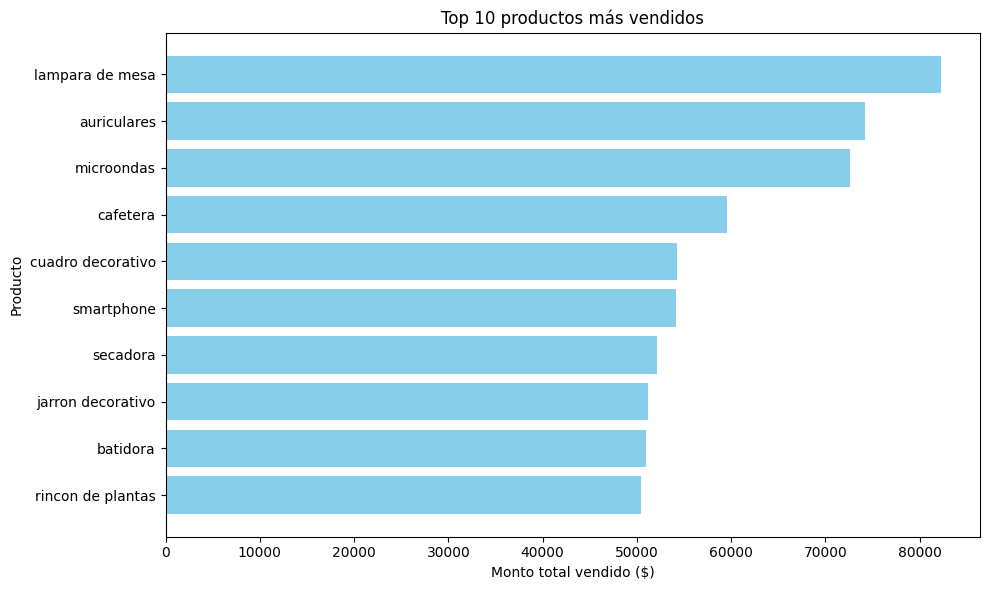

In [50]:
# Seleccionar los 10 productos más vendidos (por monto)
top_productos = dic_dfs["df_cant_ventas_totales"].sort_values('precio_total', ascending= False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top_productos['producto'], top_productos['precio_total'], color='skyblue')
plt.title('Top 10 productos más vendidos')
plt.xlabel('Monto total vendido ($)')
plt.ylabel('Producto')
plt.gca().invert_yaxis()  # El más alto arriba
plt.tight_layout()
plt.show()

In [51]:
nombres_nuevos = {
                "ventas_y_cant_totales.csv":dic_dfs["df_cant_ventas_totales"],
                "ventas_marketing.csv":dic_dfs["df_ventas_marketing"],
                "ventas_por_canal.csv":dic_dfs["df_ventas_por_canal"],
                "ventas_categoria_canal.csv":dic_dfs["df_ventas_categoria_canal"]
                 }

for nombre_nuevo,df_actual in nombres_nuevos.items():
    print(f'nombre_nuevo = {nombre_nuevo}')
    ruta_guardado = carpeta_limpios / nombre_nuevo
    guardar_csv(df_actual, ruta_guardado)
    print(f'Guardado cleaned en: {ruta_guardado}')

nombre_nuevo = ventas_y_cant_totales.csv
Guardado cleaned en: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida\limpios\ventas_y_cant_totales.csv
nombre_nuevo = ventas_marketing.csv
Guardado cleaned en: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida\limpios\ventas_marketing.csv
nombre_nuevo = ventas_por_canal.csv
Guardado cleaned en: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida\limpios\ventas_por_canal.csv
nombre_nuevo = ventas_categoria_canal.csv
Guardado cleaned en: D:\Desktop\Domingo\df_caba_y_jupyter\datasets_salida\limpios\ventas_categoria_canal.csv


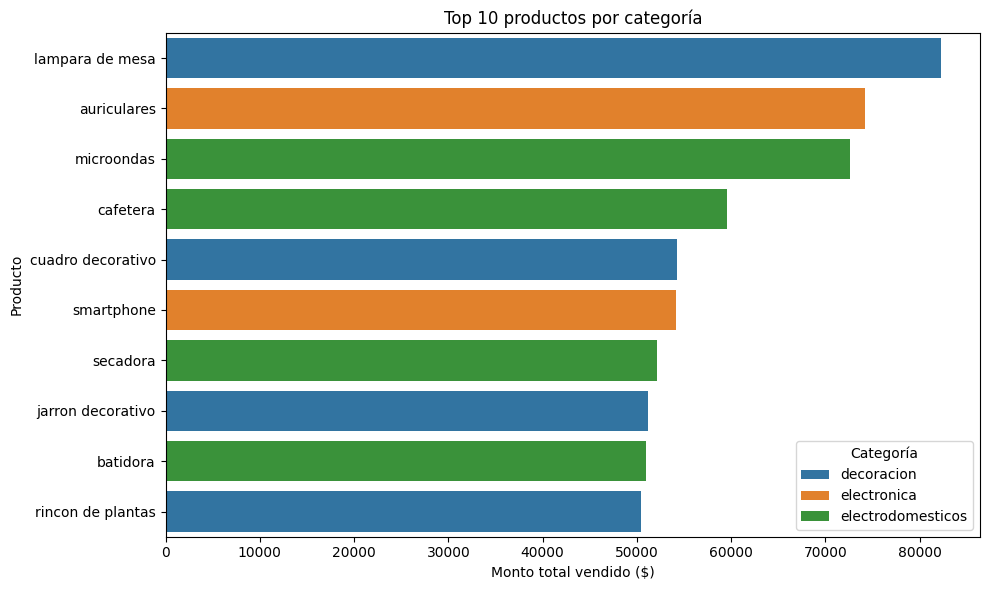

In [52]:
plt.figure(figsize=(10,6))
sns.barplot(data=top_productos, x='precio_total', y='producto', hue='categoria')
plt.title('Top 10 productos por categoría')
plt.xlabel('Monto total vendido ($)')
plt.ylabel('Producto')
plt.legend(title='Categoría')
plt.tight_layout()
plt.show()

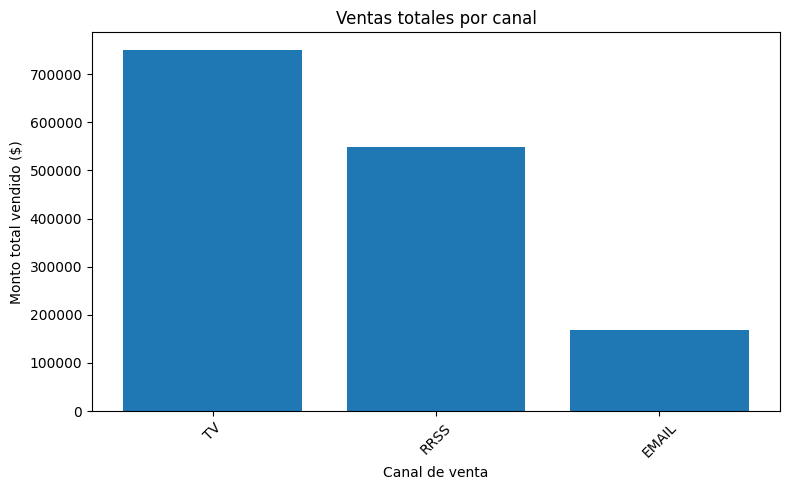

In [53]:
plt.figure(figsize=(8,5))
plt.bar(ventas_por_canal['canal'], ventas_por_canal['total_monto'])
plt.title('Ventas totales por canal')
plt.xlabel('Canal de venta')
plt.ylabel('Monto total vendido ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4.9 Reportes
##  4.9.1 Reportes ventas_mensuales

In [54]:
print (f"""Elimino dia de fecha para que quede YYYY/MM
{dic_dfs["df_ventas"].columns}
""")

dic_dfs["df_ventas"]['mes'] = dic_dfs["df_ventas"]['fecha_venta'].dt.to_period('M').astype(str)
ventas_mensuales = (
    dic_dfs["df_ventas"].groupby('mes', dropna=False)
         .agg(
             cantidad_total=('cantidad', 'sum'),
             precio_total=('precio_total', 'sum')
         )
         .reset_index()
         .sort_values('mes')
)

print(f"""{Fore.WHITE+Back.BLUE}\n
╔═════════════════════════════════════════════════════════════════════════════╗
║                             REPORTE VENTAS MENSUALES                        ║
╠═════════════════════════════════════════════════════════════════════════════╣""")
for idx, fila in ventas_mensuales.iterrows():
    print(f"""║ {f"Mes: {fila['mes']},   Cantidad total: {fila['cantidad_total']},   Monto total: {fila['precio_total']}".ljust(75)} ║""")
print (f"""╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")

Elimino dia de fecha para que quede YYYY/MM
Index(['id_venta', 'producto', 'precio', 'cantidad', 'fecha_venta',
       'categoria', 'precio_total'],
      dtype='object')



╔═════════════════════════════════════════════════════════════════════════════╗
║                             REPORTE VENTAS MENSUALES                        ║
╠═════════════════════════════════════════════════════════════════════════════╣
║ Mes: 2024-01,   Cantidad total: 1741.0,   Monto total: 129604.9921875       ║
║ Mes: 2024-02,   Cantidad total: 1607.0,   Monto total: 118672.4375          ║
║ Mes: 2024-03,   Cantidad total: 1792.0,   Monto total: 136779.15625         ║
║ Mes: 2024-04,   Cantidad total: 1715.0,   Monto total: 128430.6875          ║
║ Mes: 2024-05,   Cantidad total: 1812.0,   Monto total: 143727.25            ║
║ Mes: 2024-06,   Cantidad total: 1426.0,   Monto total: 108480.171875        ║
║ Mes: 2024-07,   Cantidad total: 1547.0,   Monto total: 116229.96875         ║
║ Mes: 2024-08,   Cantidad

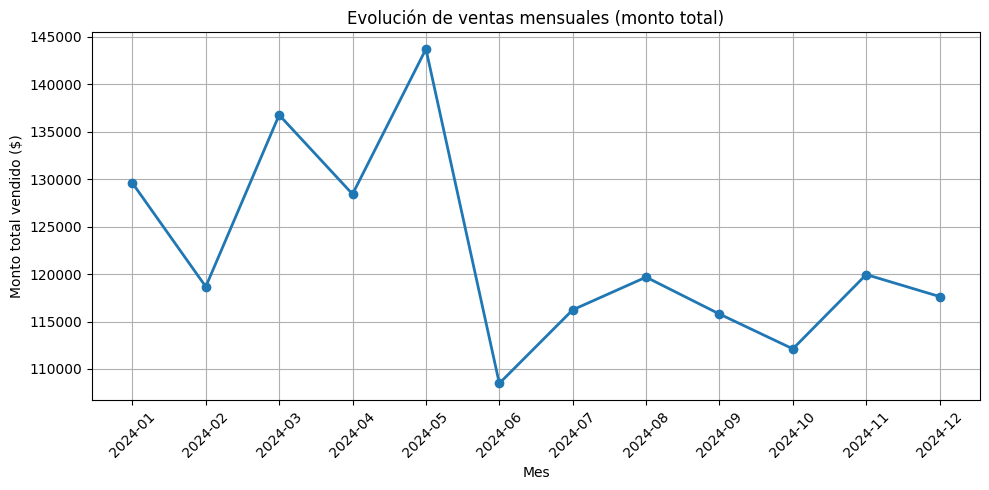

In [55]:
# monto total por mes 1
plt.figure(figsize=(10,5))
plt.plot(ventas_mensuales['mes'], ventas_mensuales['precio_total'], marker='o', linewidth=2)
plt.title('Evolución de ventas mensuales (monto total)')
plt.xlabel('Mes')
plt.ylabel('Monto total vendido ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


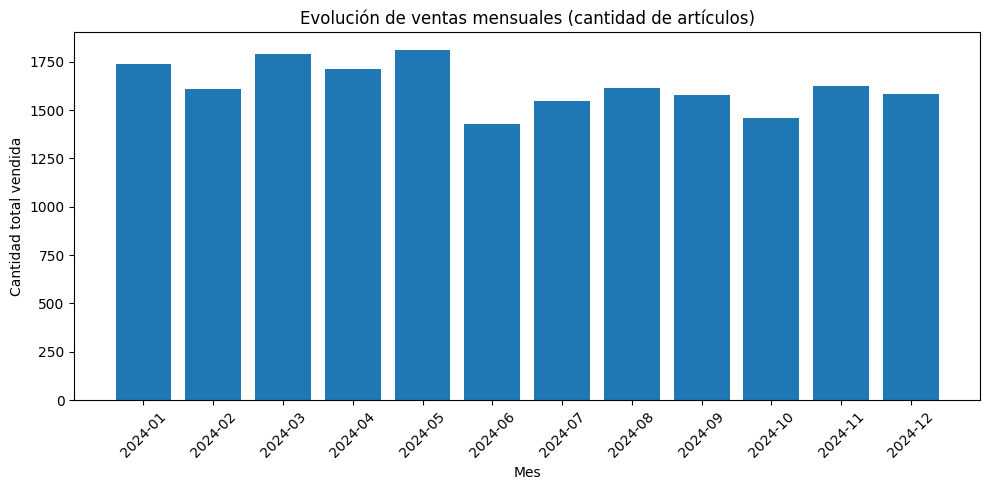

In [56]:
#  cantidad total por mes 2
plt.figure(figsize=(10,5))
plt.bar(ventas_mensuales['mes'], ventas_mensuales['cantidad_total'])
plt.title('Evolución de ventas mensuales (cantidad de artículos)')
plt.xlabel('Mes')
plt.ylabel('Cantidad total vendida')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

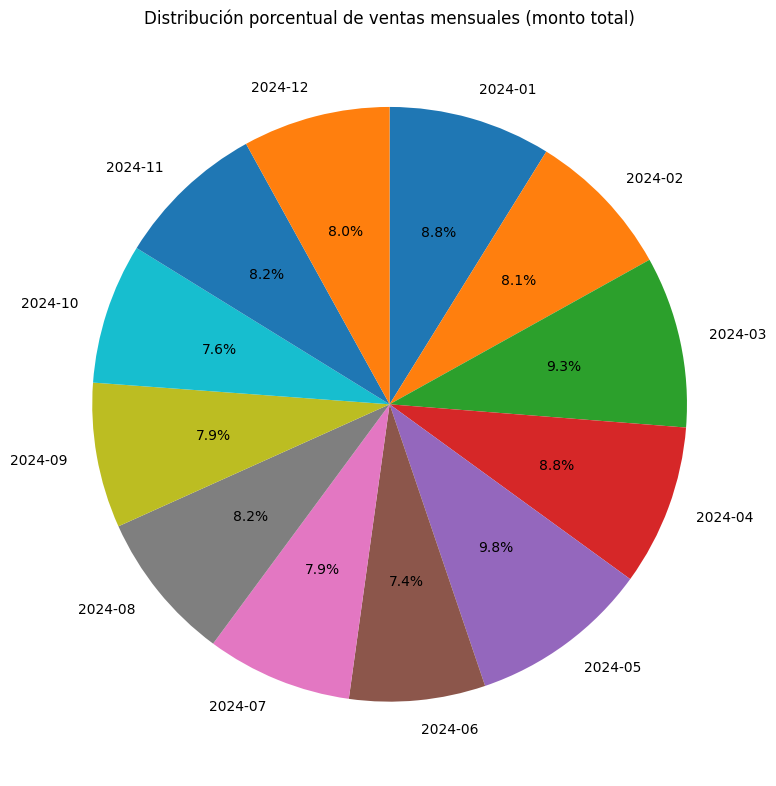

In [57]:
#  precio total por mes 3 torta
plt.figure(figsize=(8, 8))
plt.pie(
    ventas_mensuales['precio_total'],
    labels=ventas_mensuales['mes'],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)

plt.title('Distribución porcentual de ventas mensuales (monto total)')
plt.tight_layout()
plt.show()

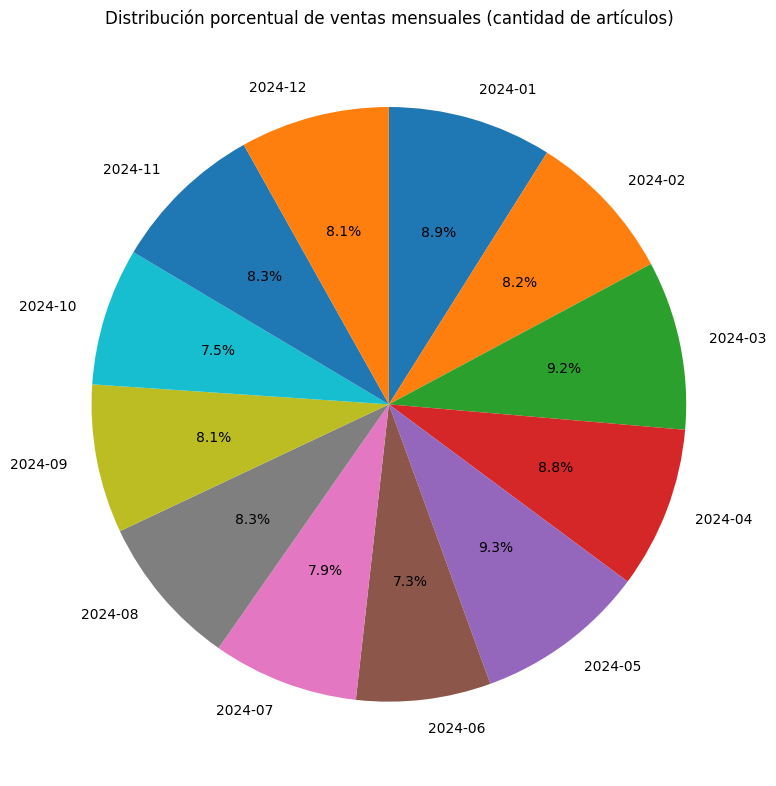

In [58]:
#  monto total por mes 3 torta
plt.figure(figsize=(8, 8))
plt.pie(
    ventas_mensuales['cantidad_total'],
    labels=ventas_mensuales['mes'],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)
plt.title('Distribución porcentual de ventas mensuales (cantidad de artículos)')
plt.tight_layout()
plt.show()

## 4.9.2 Reportes percentil_80

In [59]:
percentil_80 = dic_dfs["df_ventas"]["precio_total"].quantile(0.80)
print(f"")
print(f"""{Fore.WHITE+Back.BLUE}\n
╔═════════════════════════════════════════════════════════════════════════════╗
║                              REPORTE VENTAS TOTALES                         ║
║                 El percentil 80 del valor total es: {str(round(percentil_80,2)).center(10)}              ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")




╔═════════════════════════════════════════════════════════════════════════════╗
║                              REPORTE VENTAS TOTALES                         ║
║                 El percentil 80 del valor total es:   787.34                ║
╚═════════════════════════════════════════════════════════════════════════════╝


"
Index(['id_venta', 'producto', 'precio', 'cantidad', 'fecha_venta',
       'categoria', 'precio_total', 'mes'],
      dtype='object')




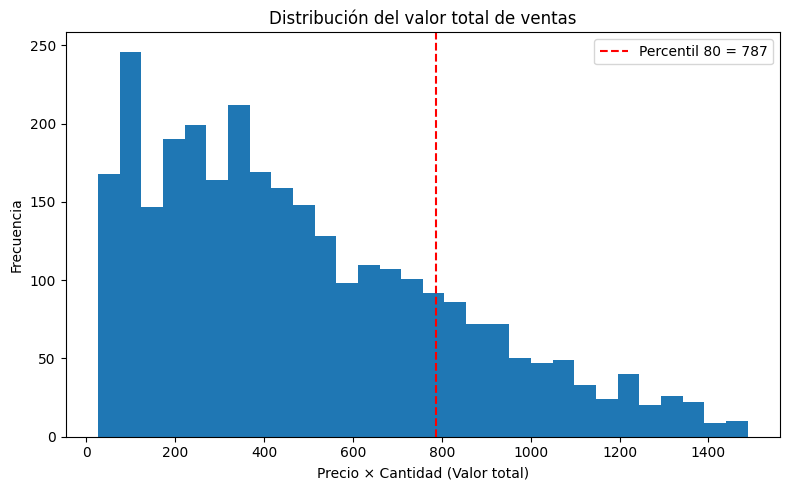

In [60]:
print (F""""
{dic_dfs["df_ventas"].columns}

""")
plt.figure(figsize=(8,5))
plt.hist(dic_dfs["df_ventas"]["precio_total"], bins=30)
plt.axvline(percentil_80, color='red', linestyle='--', label=f'Percentil 80 = {percentil_80:,.0f}')
plt.title("Distribución del valor total de ventas")
plt.xlabel("Precio × Cantidad (Valor total)")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

## 4.9.3 Reportes ventas_alto_rendimiento

In [61]:
#Filtrar las ventas “de alto rendimiento”
ventas_alto_rendimiento = dic_dfs["df_ventas"][
    dic_dfs["df_ventas"]["precio_total"] > percentil_80
]

print(f"Ventas de alto rendimiento encontradas: {len(ventas_alto_rendimiento)} registros")
print (ventas_alto_rendimiento.columns)
print (ventas_alto_rendimiento.head())
#Index(['id_venta', 'producto', 'precio', 'cantidad', 'fecha_venta', 'categoria', 'precio_total', 'mes
print(f"""{Fore.WHITE+Back.BLUE}\n
╔═════════════════════════════════════════════════════════════════════════════╗
║                      REPORTE VENTAS DE ALTO RENDIMIENTO                     ║
║             50 primeras ventas de alto rendimiento encontradas              ║
╠═════════════════════════════════════════════════════════════════════════════╣""")
for idx, fila in ventas_alto_rendimiento.head(50).iterrows():
    print(f"""║ {f"Mes: {fila['mes']},   Cantidad total: {fila['cantidad']},   Monto total: {fila['precio_total']}".ljust(75)} ║""")
print (f"""╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")

Ventas de alto rendimiento encontradas: 600 registros
Index(['id_venta', 'producto', 'precio', 'cantidad', 'fecha_venta',
       'categoria', 'precio_total', 'mes'],
      dtype='object')
    id_venta           producto      precio  cantidad fecha_venta  \
3       1372           heladera  114.349998       8.0  2024-01-02   
7       2959          proyector   88.169998       9.0  2024-01-02   
8        318  rincon de plantas   79.860001      11.0  2024-01-03   
19       882  cuadro decorativo  101.919998       9.0  2024-01-04   
20       969         candelabro   90.699997      12.0  2024-01-04   

            categoria  precio_total      mes  
3   electrodomesticos    914.799988  2024-01  
7         electronica    793.529968  2024-01  
8          decoracion    878.460022  2024-01  
19         decoracion    917.279968  2024-01  
20         decoracion   1088.399902  2024-01  


╔═════════════════════════════════════════════════════════════════════════════╗
║                      REPORTE VE